# Yolov7 Training and Inference

In this notebook we will perform transfer learning using YOLO (You Only Look Once) v7 model, which is the latest version of YOLO models single stage object detectors. To do so, we will use as reference this [GitHub repository](https://github.com/WongKinYiu/yolov7.git), which we cloned and used for our object detection task. We trained all the models below for 50 ```epochs``` (~6 hours per model) and ```batch_size``` of 8 using the pretrained yolo weights (```yolov7_training.pt```) and creating dedicated _.yaml_ files for each model. We also changed the ```img_size``` to 256 both for computational reasons and to be consistent with the image definition used for training the FasterR-CNN.

In [1]:
# cloning official YOLOv7 repository
!git clone https://github.com/WongKinYiu/yolov7.git

In [6]:
# moving yaml files to yolo directory
!mv yaml yolov7/yaml

## Table of Contents
1. [Colored Model](#aug_m)
2. [BW Model](#bw_m)
3. [Undersampled Model](#under_m)
4. [Oversampled Model](#over_m)
5. [Colorized predicted from RGB](#colorized)
6. [BW images predicted from RGB](#sueg)
7. [Colorized inference](#colorized)
8. [Final test](#final)
9. [Test on videos](#video)

In [4]:
# importing libraries
from PIL import Image
import cv2
from matplotlib import pyplot as plt

## 1. Base Colored Model <a class="anchor" id="aug_m"></a>

The first YOLO model we train is the one that takes as input the original colored images. As said before, we will train it for 50 epochs, with batch_size of 8 and image_size of 256.

In [3]:
!python yolov7/train.py --img-size 256 --cfg yolov7/cfg/training/yolov7-tiny.yaml --hyp yolov7/data/hyp.scratch.custom.yaml \
--batch 8 --epochs 50 --data yolov7/yaml/yolo_aves.yaml --weights yolov7/yolov7_training.pt --workers 24 --name "50_aves"

YOLOR 🚀 v0.1-115-g072f76c torch 1.9.0 CUDA:0 (Tesla K80, 11441.25MB)

Namespace(adam=False, artifact_alias='latest', batch_size=8, bbox_interval=-1, bucket='', cache_images=False, cfg='yolov7/cfg/training/yolov7-tiny.yaml', data='yolo_aves.yaml', device='', entity=None, epochs=50, evolve=False, exist_ok=False, freeze=[0], global_rank=-1, hyp='yolov7/data/hyp.scratch.custom.yaml', image_weights=False, img_size=[256, 256], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='50_aves', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/50_aves', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=8, upload_dataset=False, v5_metric=False, weights='yolov7_training.pt', workers=24, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2022-11-26 10:46:00.945865: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Su

The mAP is 0.831, suggesting that the model is good. PR-curve suggests that model is behaving well, since the area under the curve si higher than 50% and close to 1. The plot enables to study each single class, in particular we notice that the ones under the mean are Pandion and Junco. These are species quite similar to others, so it's reasonable that the model struggles a little bit. Anyway, we will discuss more this during the analysis of confusion matrix.

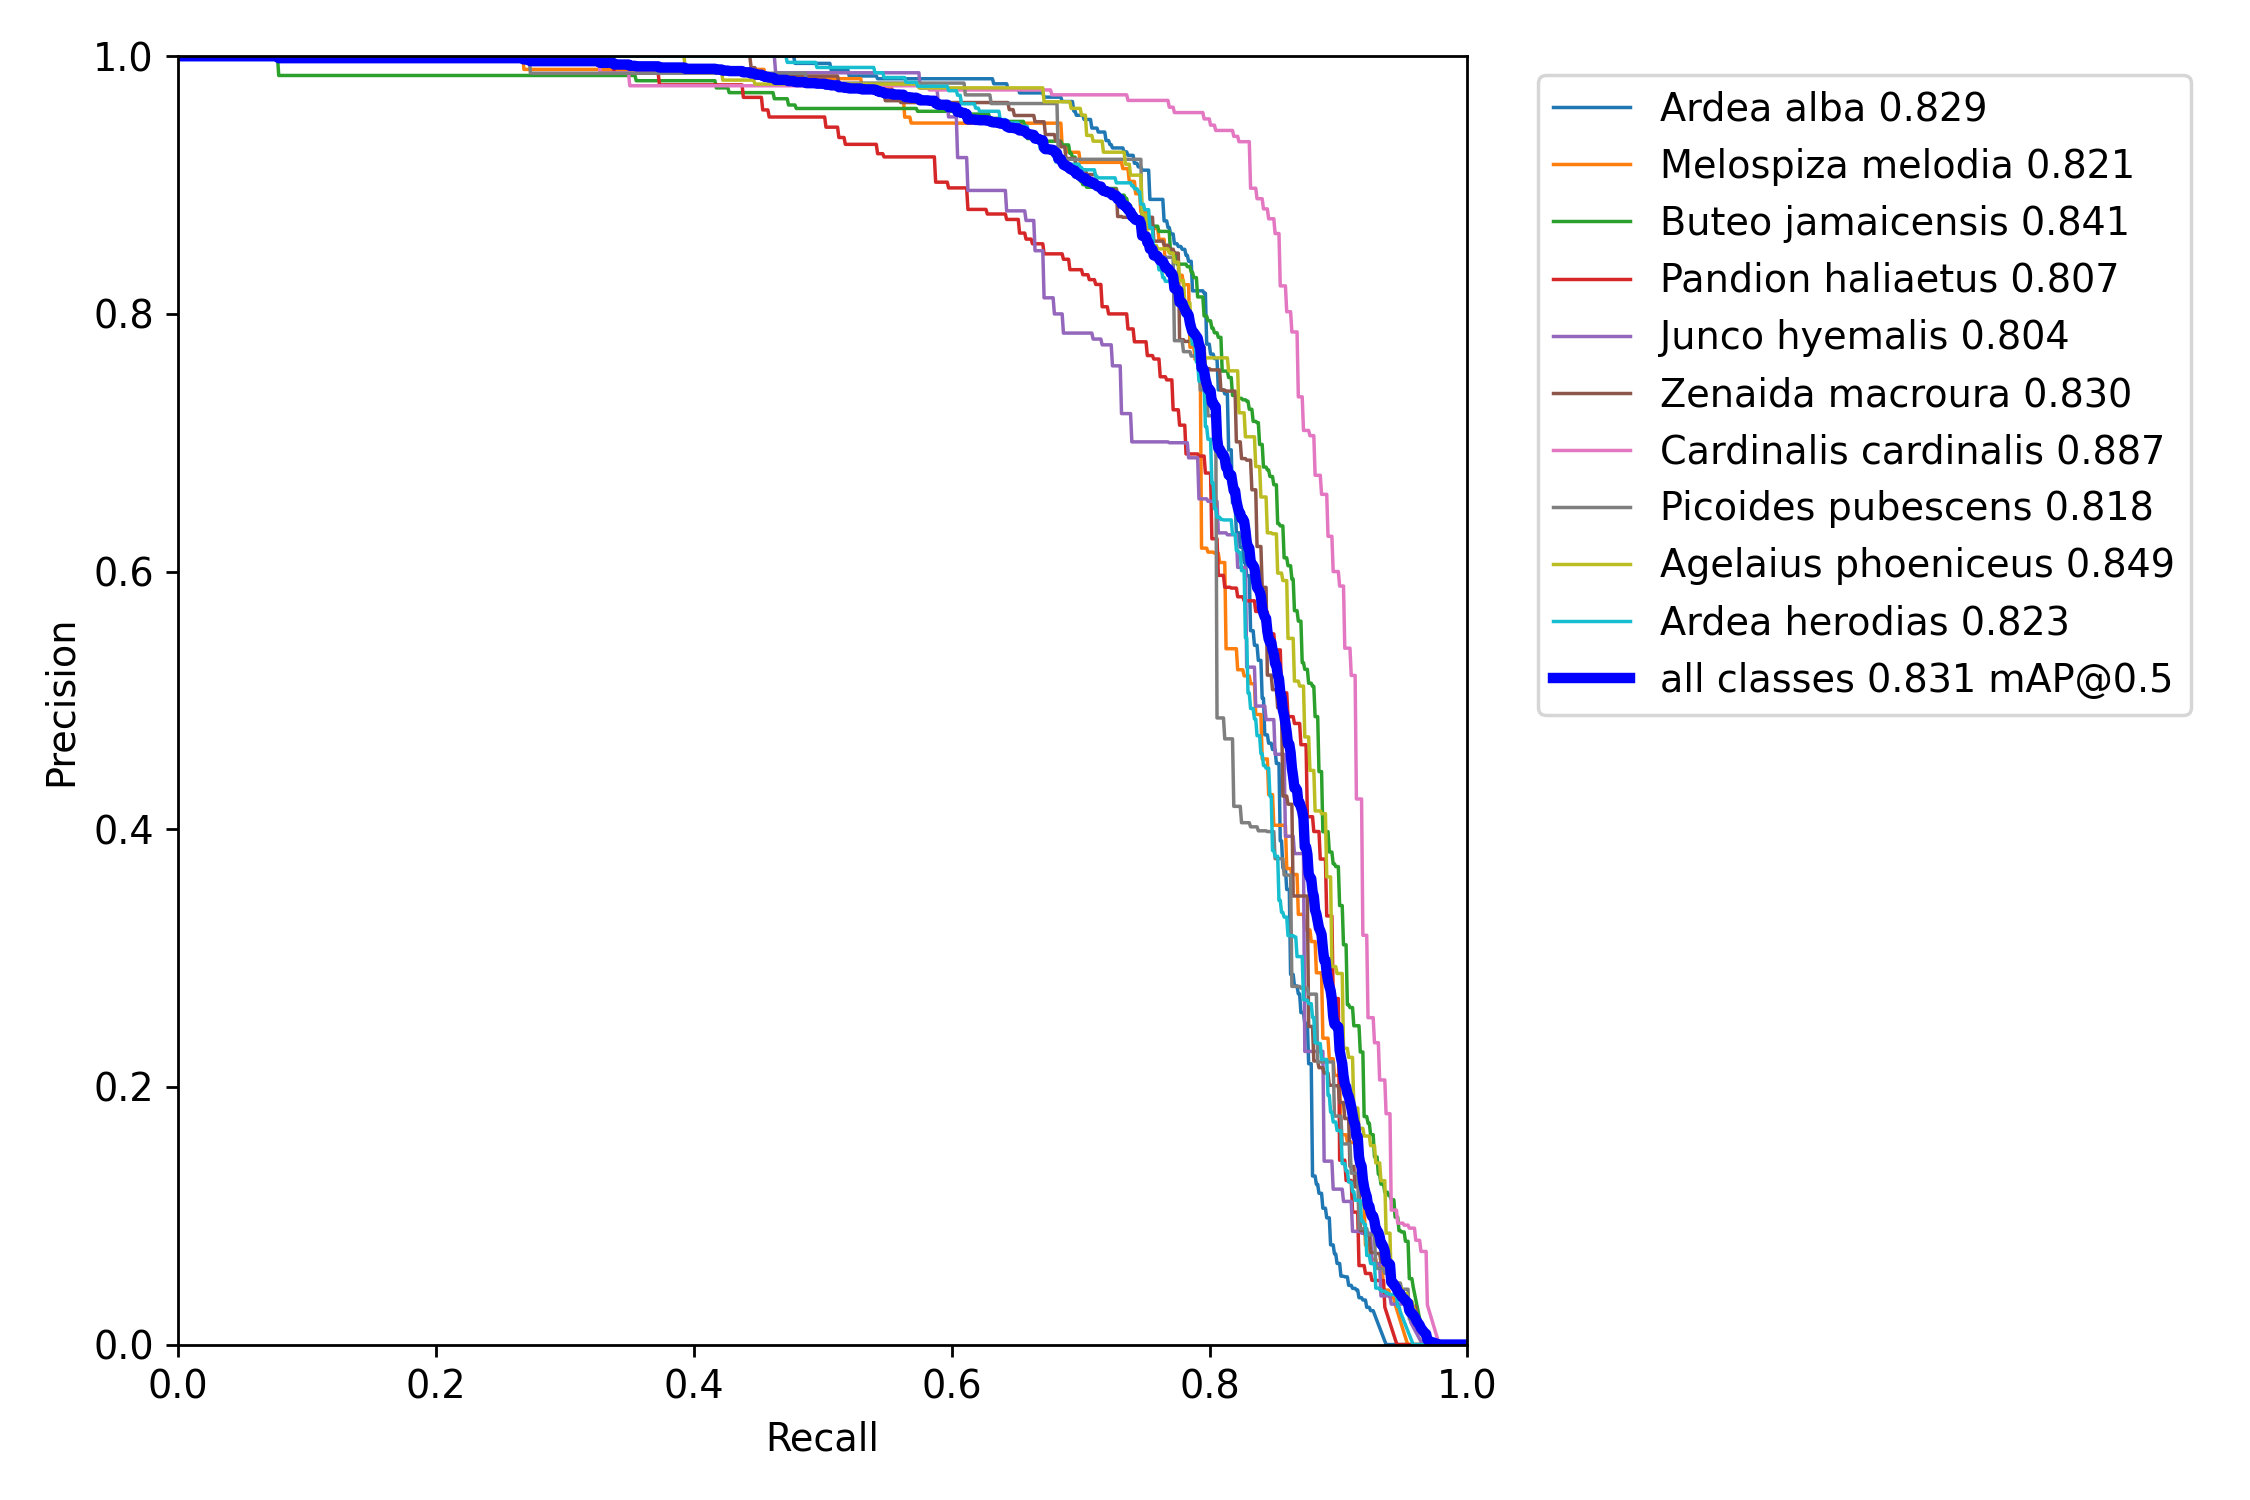

In [14]:
Image.open("runs/train/50_aves/PR_curve.png")

In the following confusion matrix we observe that most of the cases the birds are correctely classified. The only nuisance is between two classes: Buteo and Pandion. This is reasonable since the two birds are quite similar. Similar results are obtained for Melospiza and Pandion.

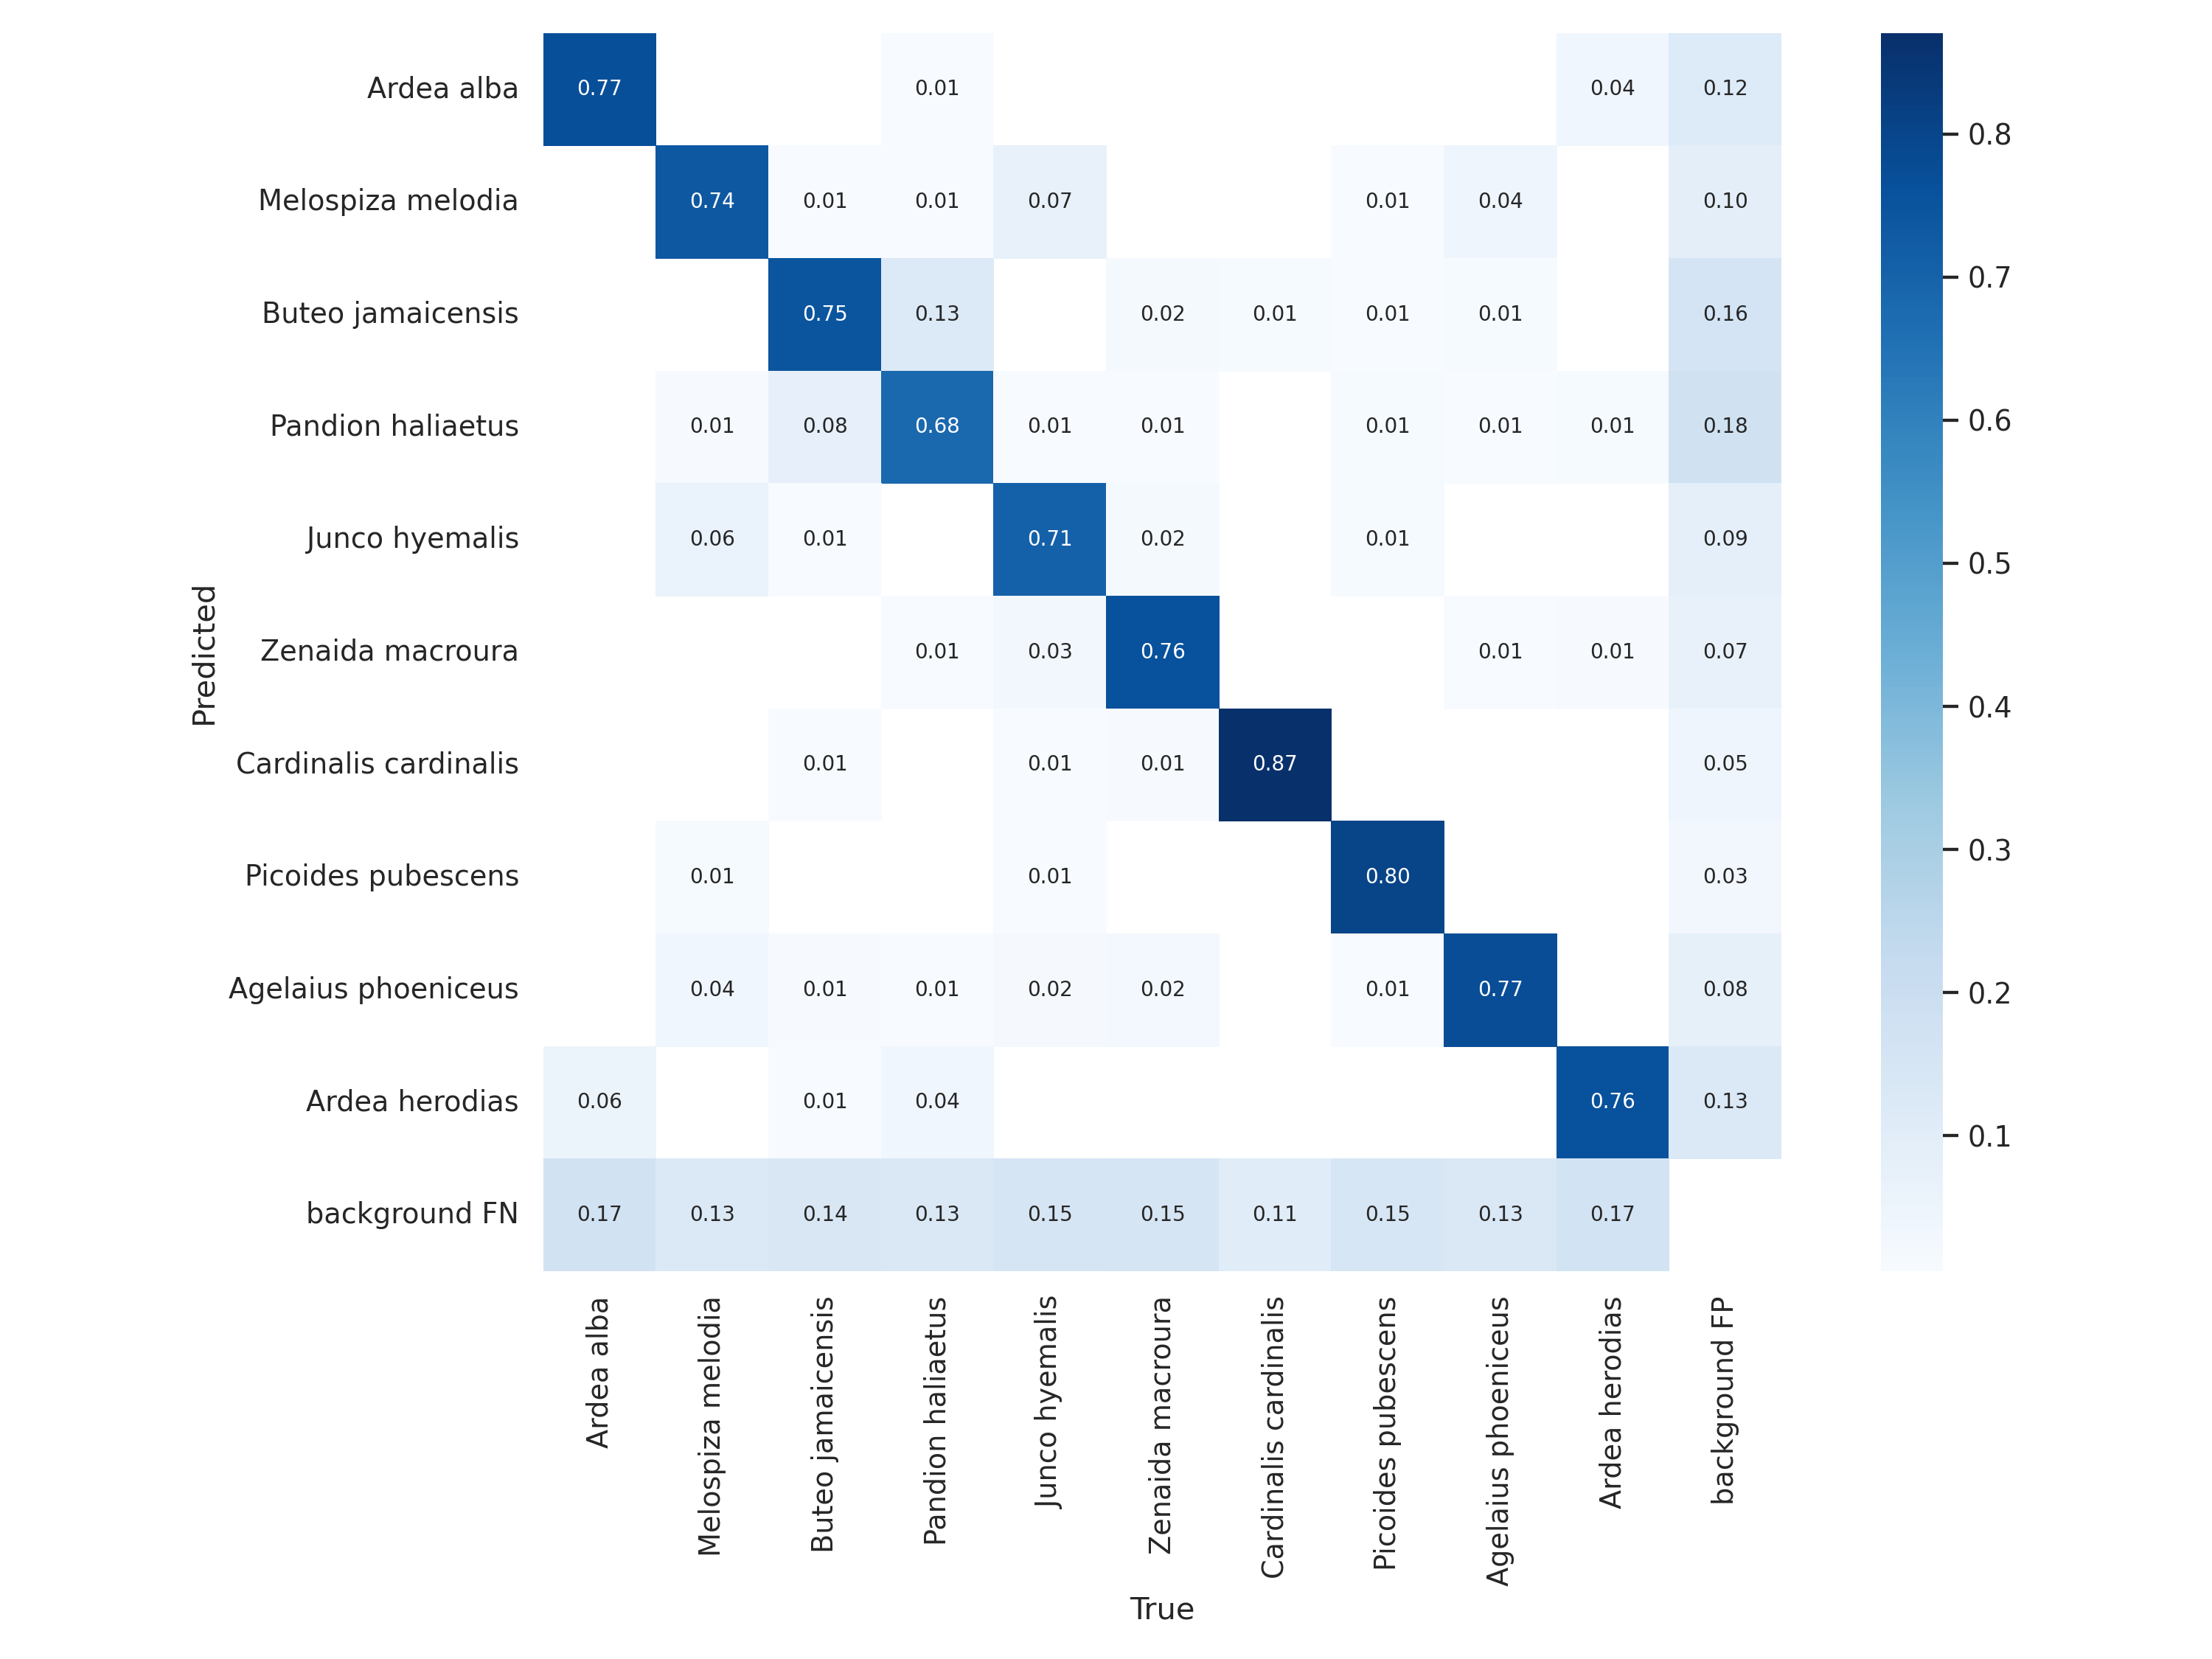

In [10]:
Image.open("runs/train/50_aves/confusion_matrix.png")

## 2. BW Model <a class="anchor" id="bw_m"></a>

Then, we tried to use as input images the black and white images we created from the original ones, averaging their 3 channels and copying the average three times, to still obtain a black and white image.

In [13]:
!python yolov7/train.py --img-size 256 --cfg yolov7/cfg/training/yolov7-tiny.yaml --hyp yolov7/data/hyp.scratch.custom.yaml \
--batch 8 --epochs 50 --data yolov7/yaml/yolo_aves_bw.yaml --weights yolov7/yolov7_training.pt --workers 24 --name "aves_bw"

YOLOR 🚀 v0.1-115-g072f76c torch 1.9.0 CUDA:0 (Tesla K80, 11441.25MB)

Namespace(adam=False, artifact_alias='latest', batch_size=8, bbox_interval=-1, bucket='', cache_images=False, cfg='yolov7/cfg/training/yolov7-tiny.yaml', data='yolo_aves_black_and_white.yaml', device='', entity=None, epochs=11, evolve=False, exist_ok=False, freeze=[0], global_rank=-1, hyp='yolov7/data/hyp.scratch.custom.yaml', image_weights=False, img_size=[256, 256], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='BW_aves', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/BW_aves2', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=8, upload_dataset=False, v5_metric=False, weights='best.pt', workers=24, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2022-11-27 20:41:23.097056: I tensorflow/stream_executor/platform/default/dso_loader.cc:

The mAP reduces to 0.741 (you can find this in the plot). This behaviour is predictable since we are removing the information of the color. In the Precision Recall curve we observe the general good performance of the model. Actually, there are two classes, Junco and Cardinalis, which struggles a little bit. The justifications could be the following:
- Junco: it's the less frequent class, meaning that if we remove also the colors, maybe we are discarding too much information from it.
- Cardinalis: this is characterized by a bright red color, so it quite obvious that removing it has an effect over the performance of the model.

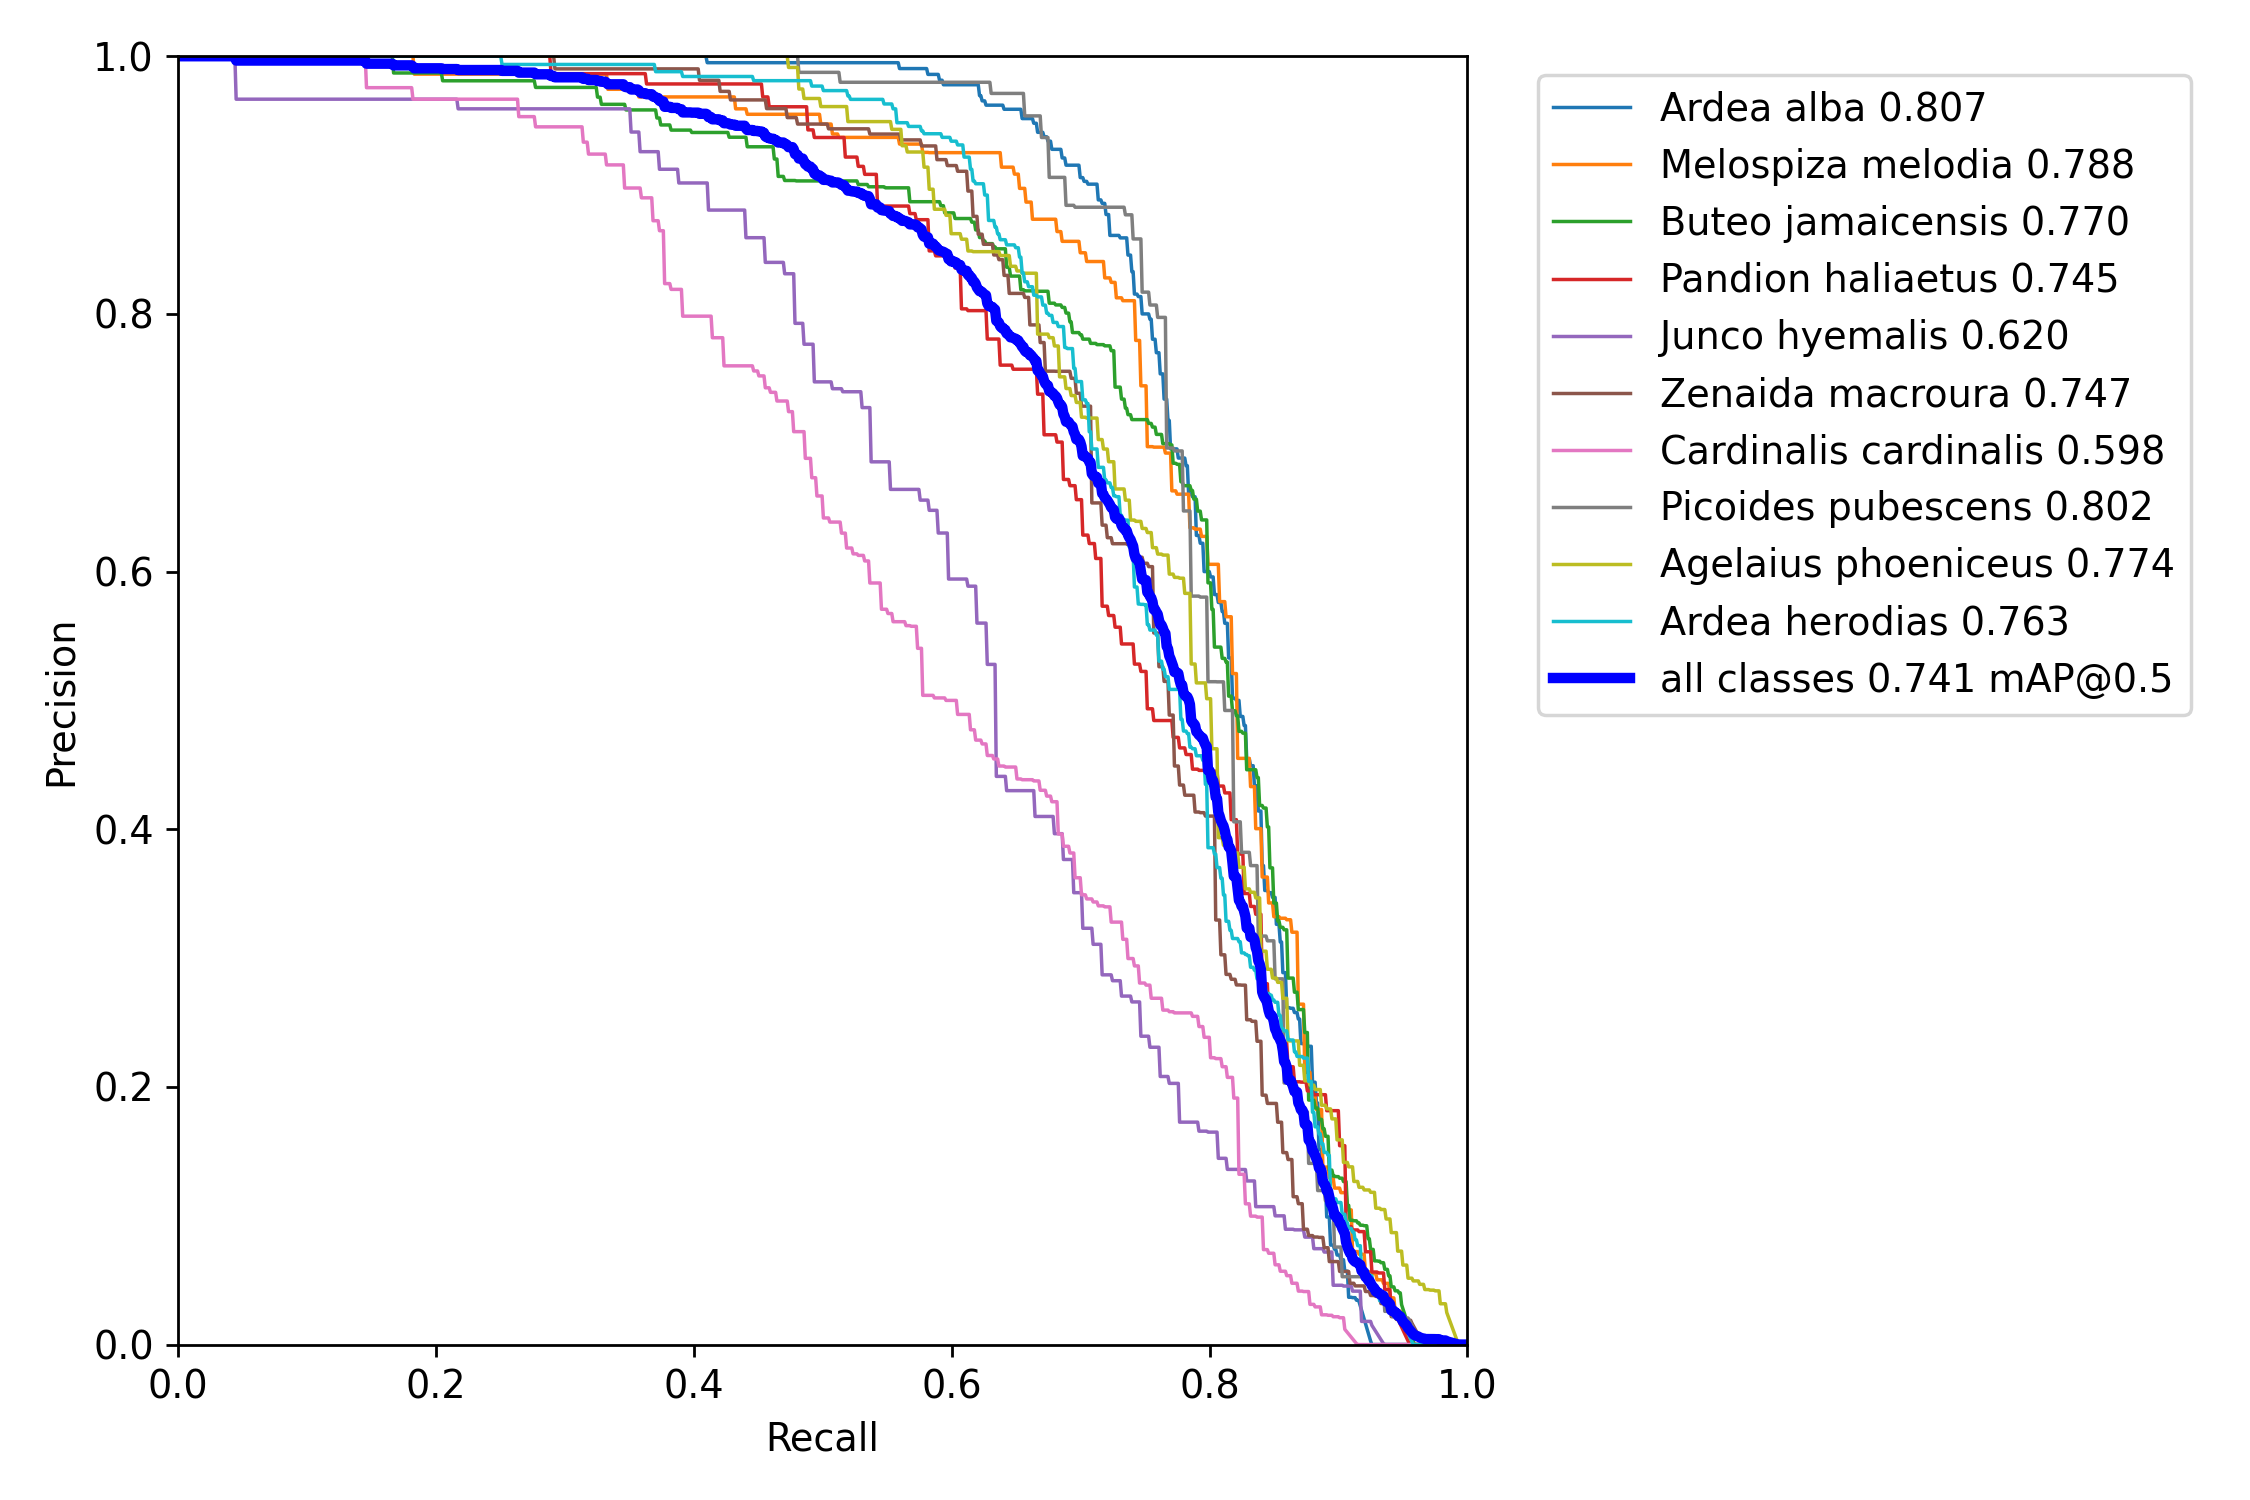

In [15]:
Image.open("runs/train/aves_bw/PR_curve.png")

The confusion matrix below also suggests that the model struggles in identifying Cardinalis: 32% of time is misclassified as background class. 

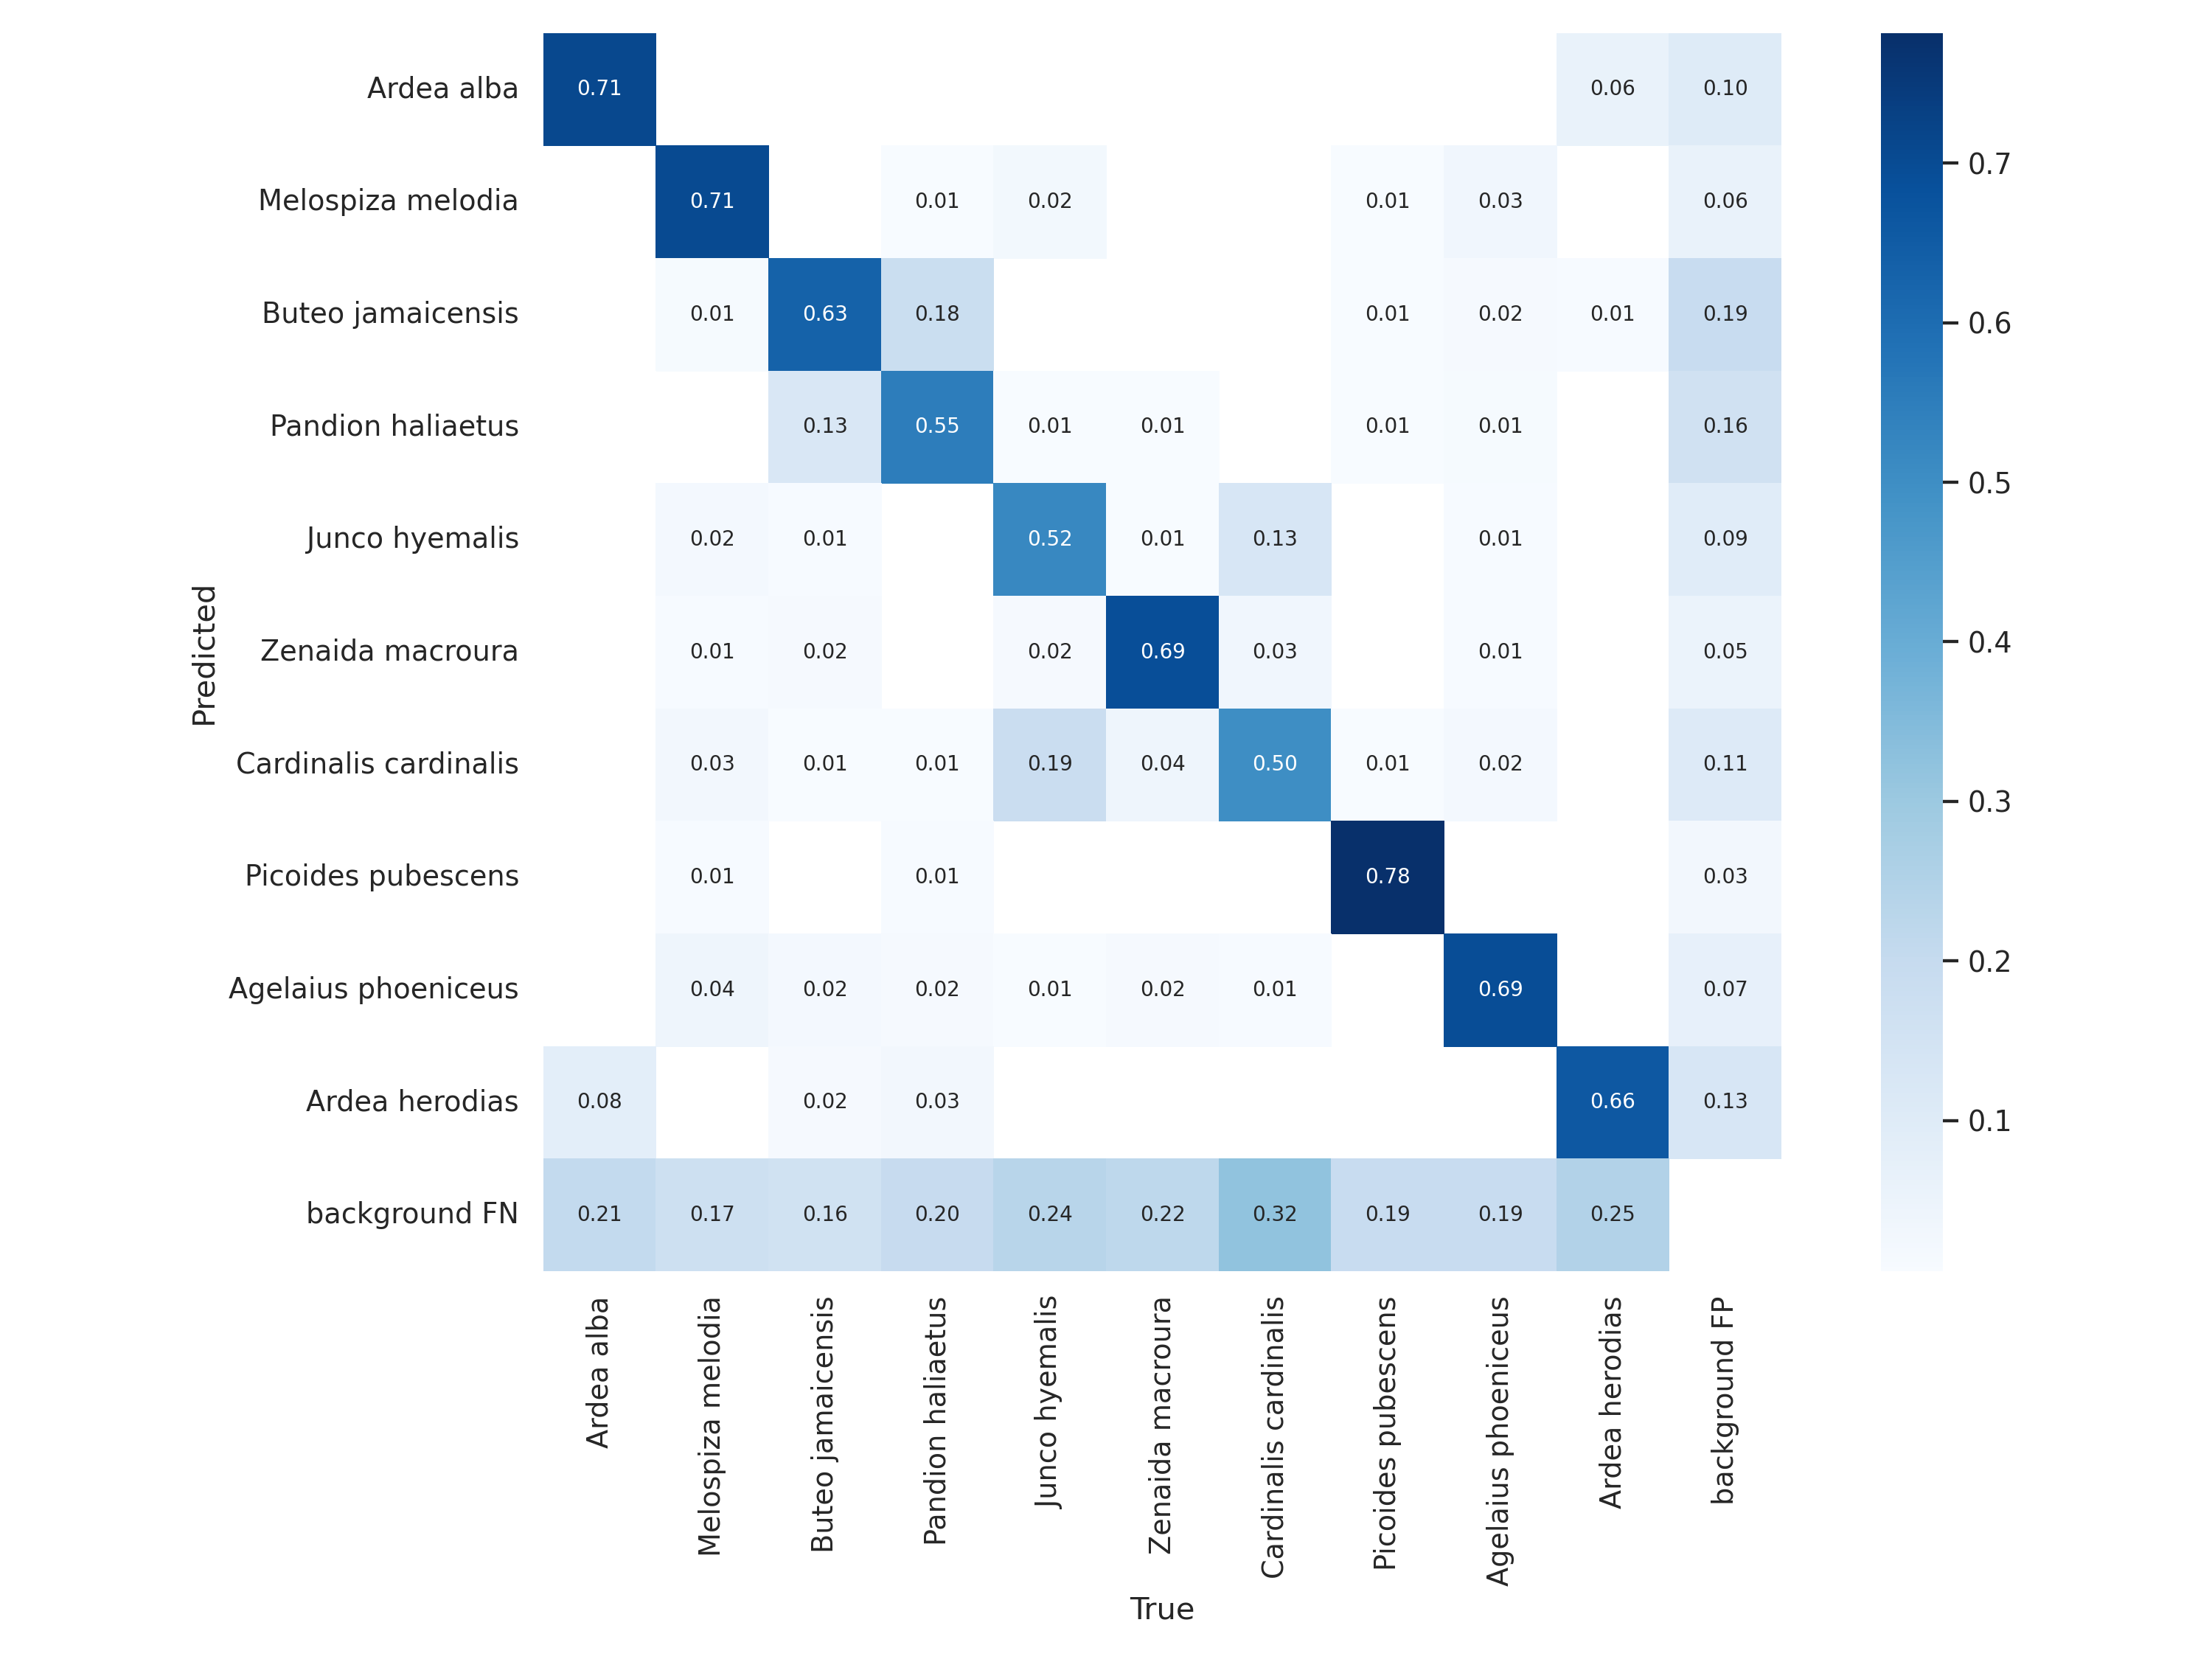

In [4]:
Image.open("runs/train/aves_bw/confusion_matrix.png")

## 3. Undersampled Model <a class="anchor" id="under_m"></a>

In this section we are training YOLO using the balanced undersampled dataset. To create this dataset we looked at the lowest class size (Junco hyemalis) and we decreased all the others to reach the same number of images.
Again, all the other parameters are the same as before, allowing us to make comparisons in the inference analysis.

In [15]:
!python yolov7/train.py --img-size 256 --cfg yolov7/cfg/training/yolov7-tiny.yaml --hyp yolov7/data/hyp.scratch.custom.yaml \
--batch 8 --epochs 50 --data yolov7/yaml/yolo_aves_under.yaml --weights yolov7/yolov7_training.pt --workers 24 --name "aves_under"

YOLOR 🚀 v0.1-115-g072f76c torch 1.9.0 CUDA:0 (Tesla K80, 11441.25MB)


The mAP reduces to 0.729. This could be explained by considering that now the amount of information is much lower, while the number of parameters to estimate remains the same.

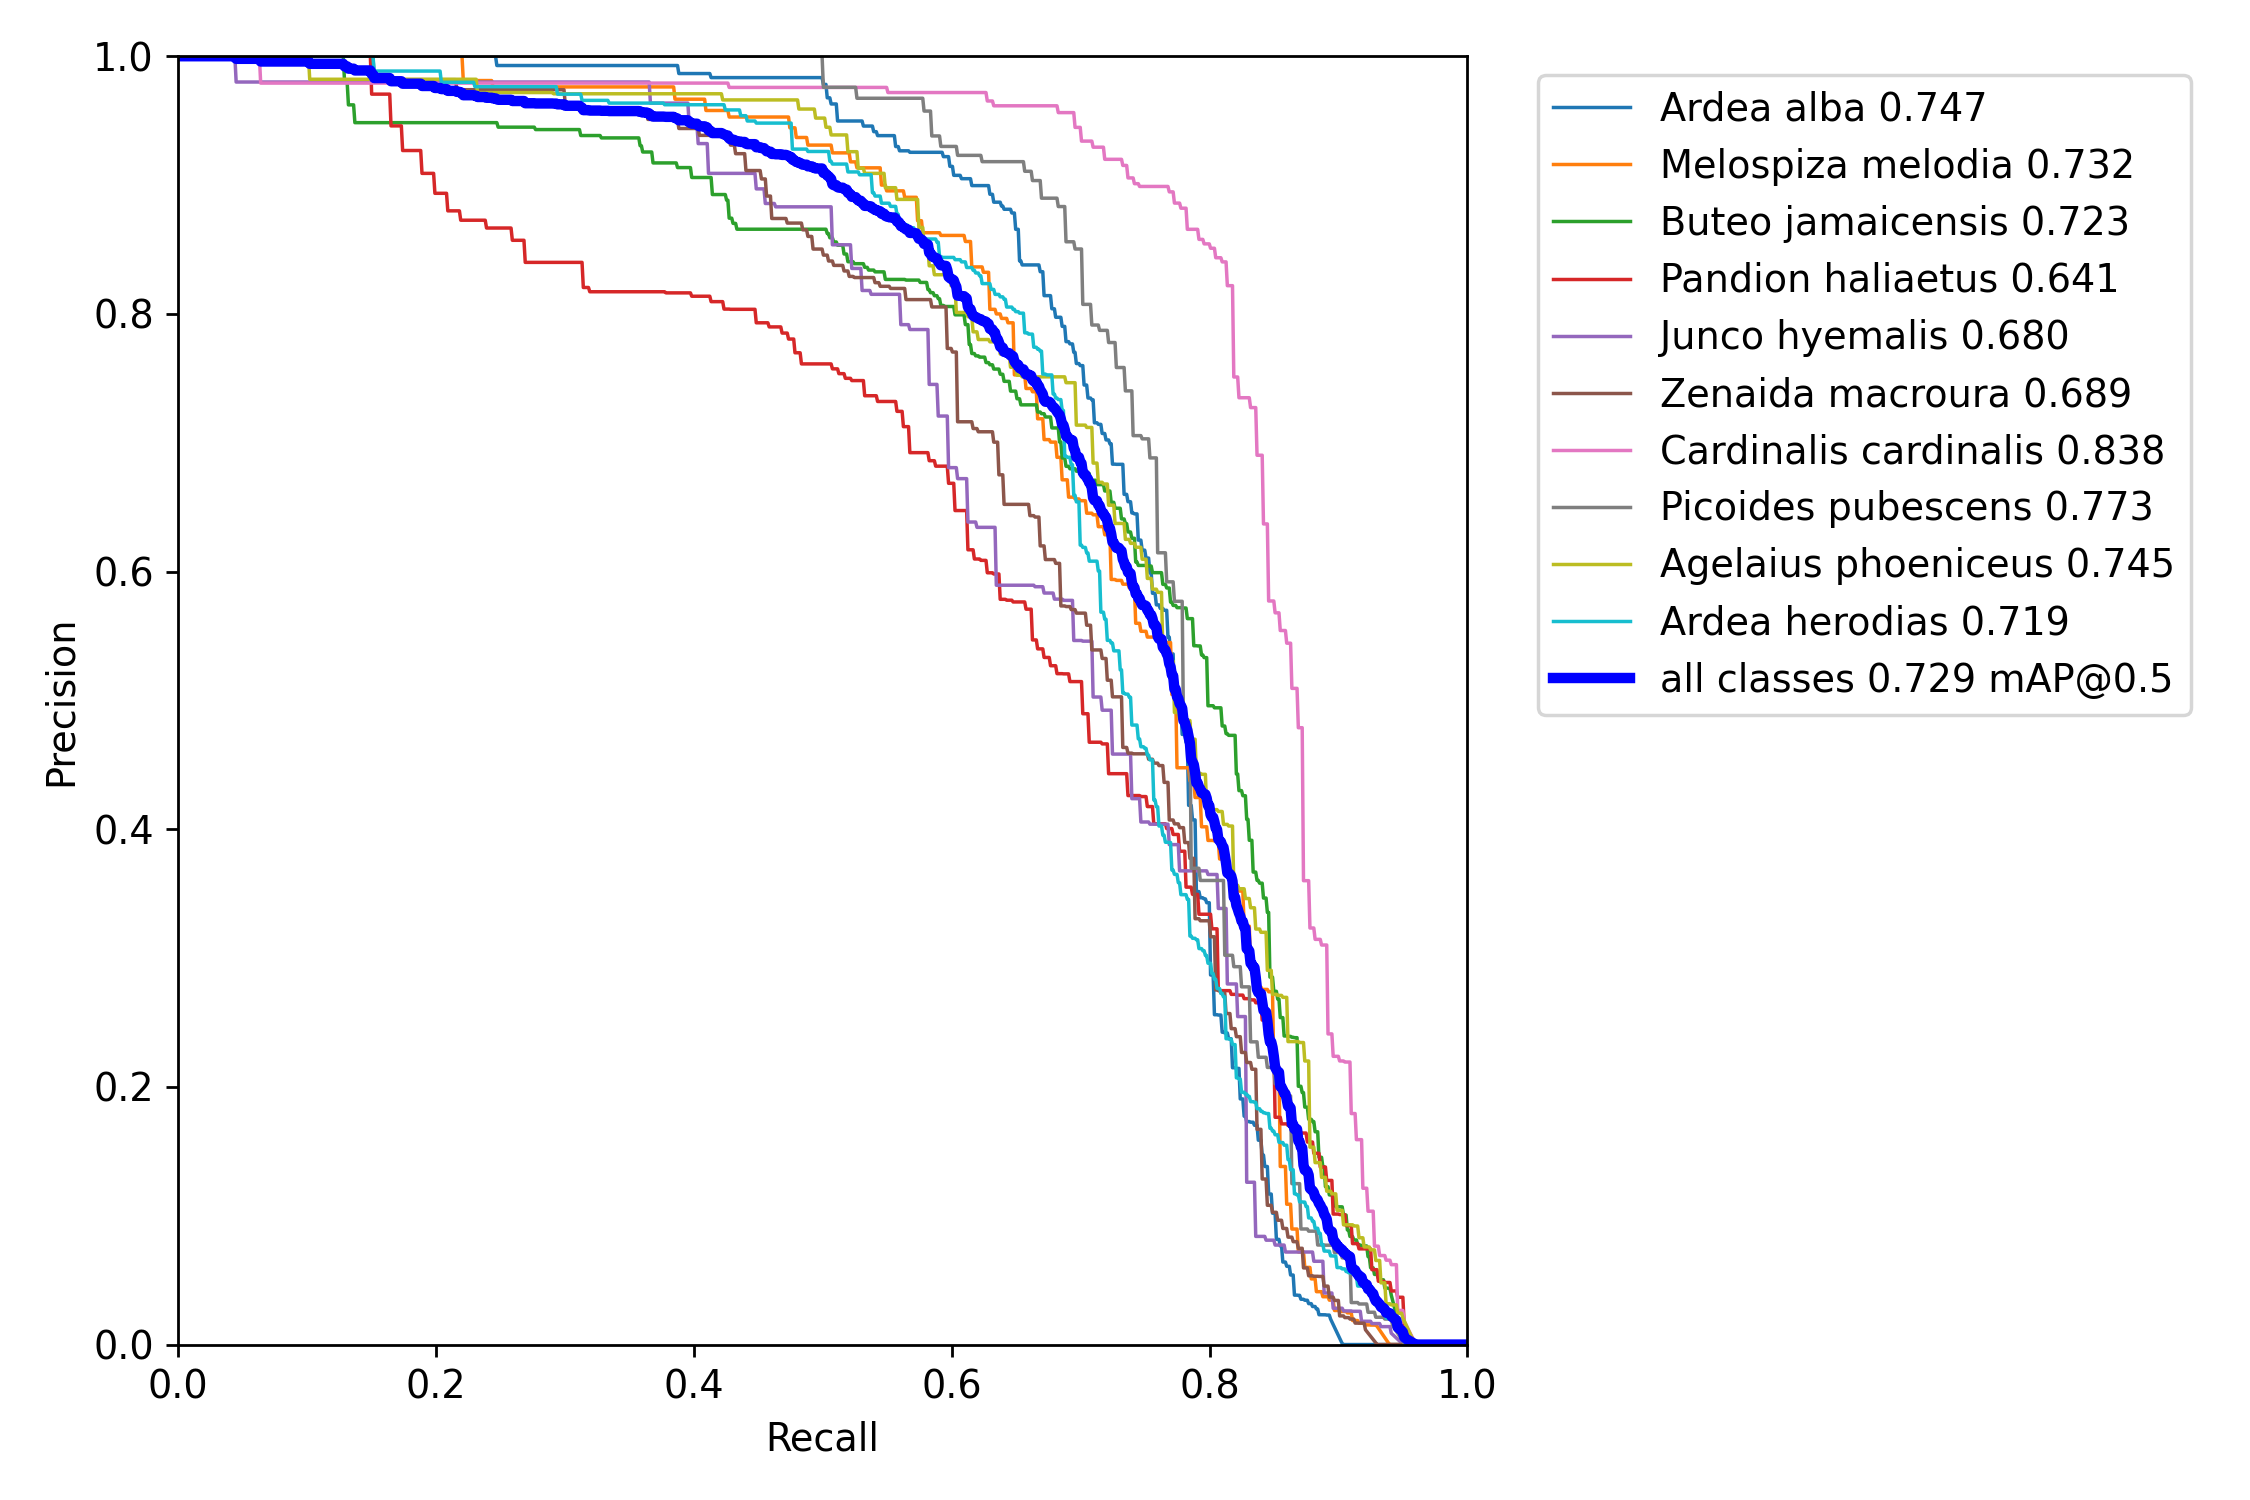

In [17]:
Image.open("runs/train/aves_under/PR_curve.png")

As expected, the recall of each class drops. In particular the difficulty of the model to distinguish Pandion and Buteo is stressed more.

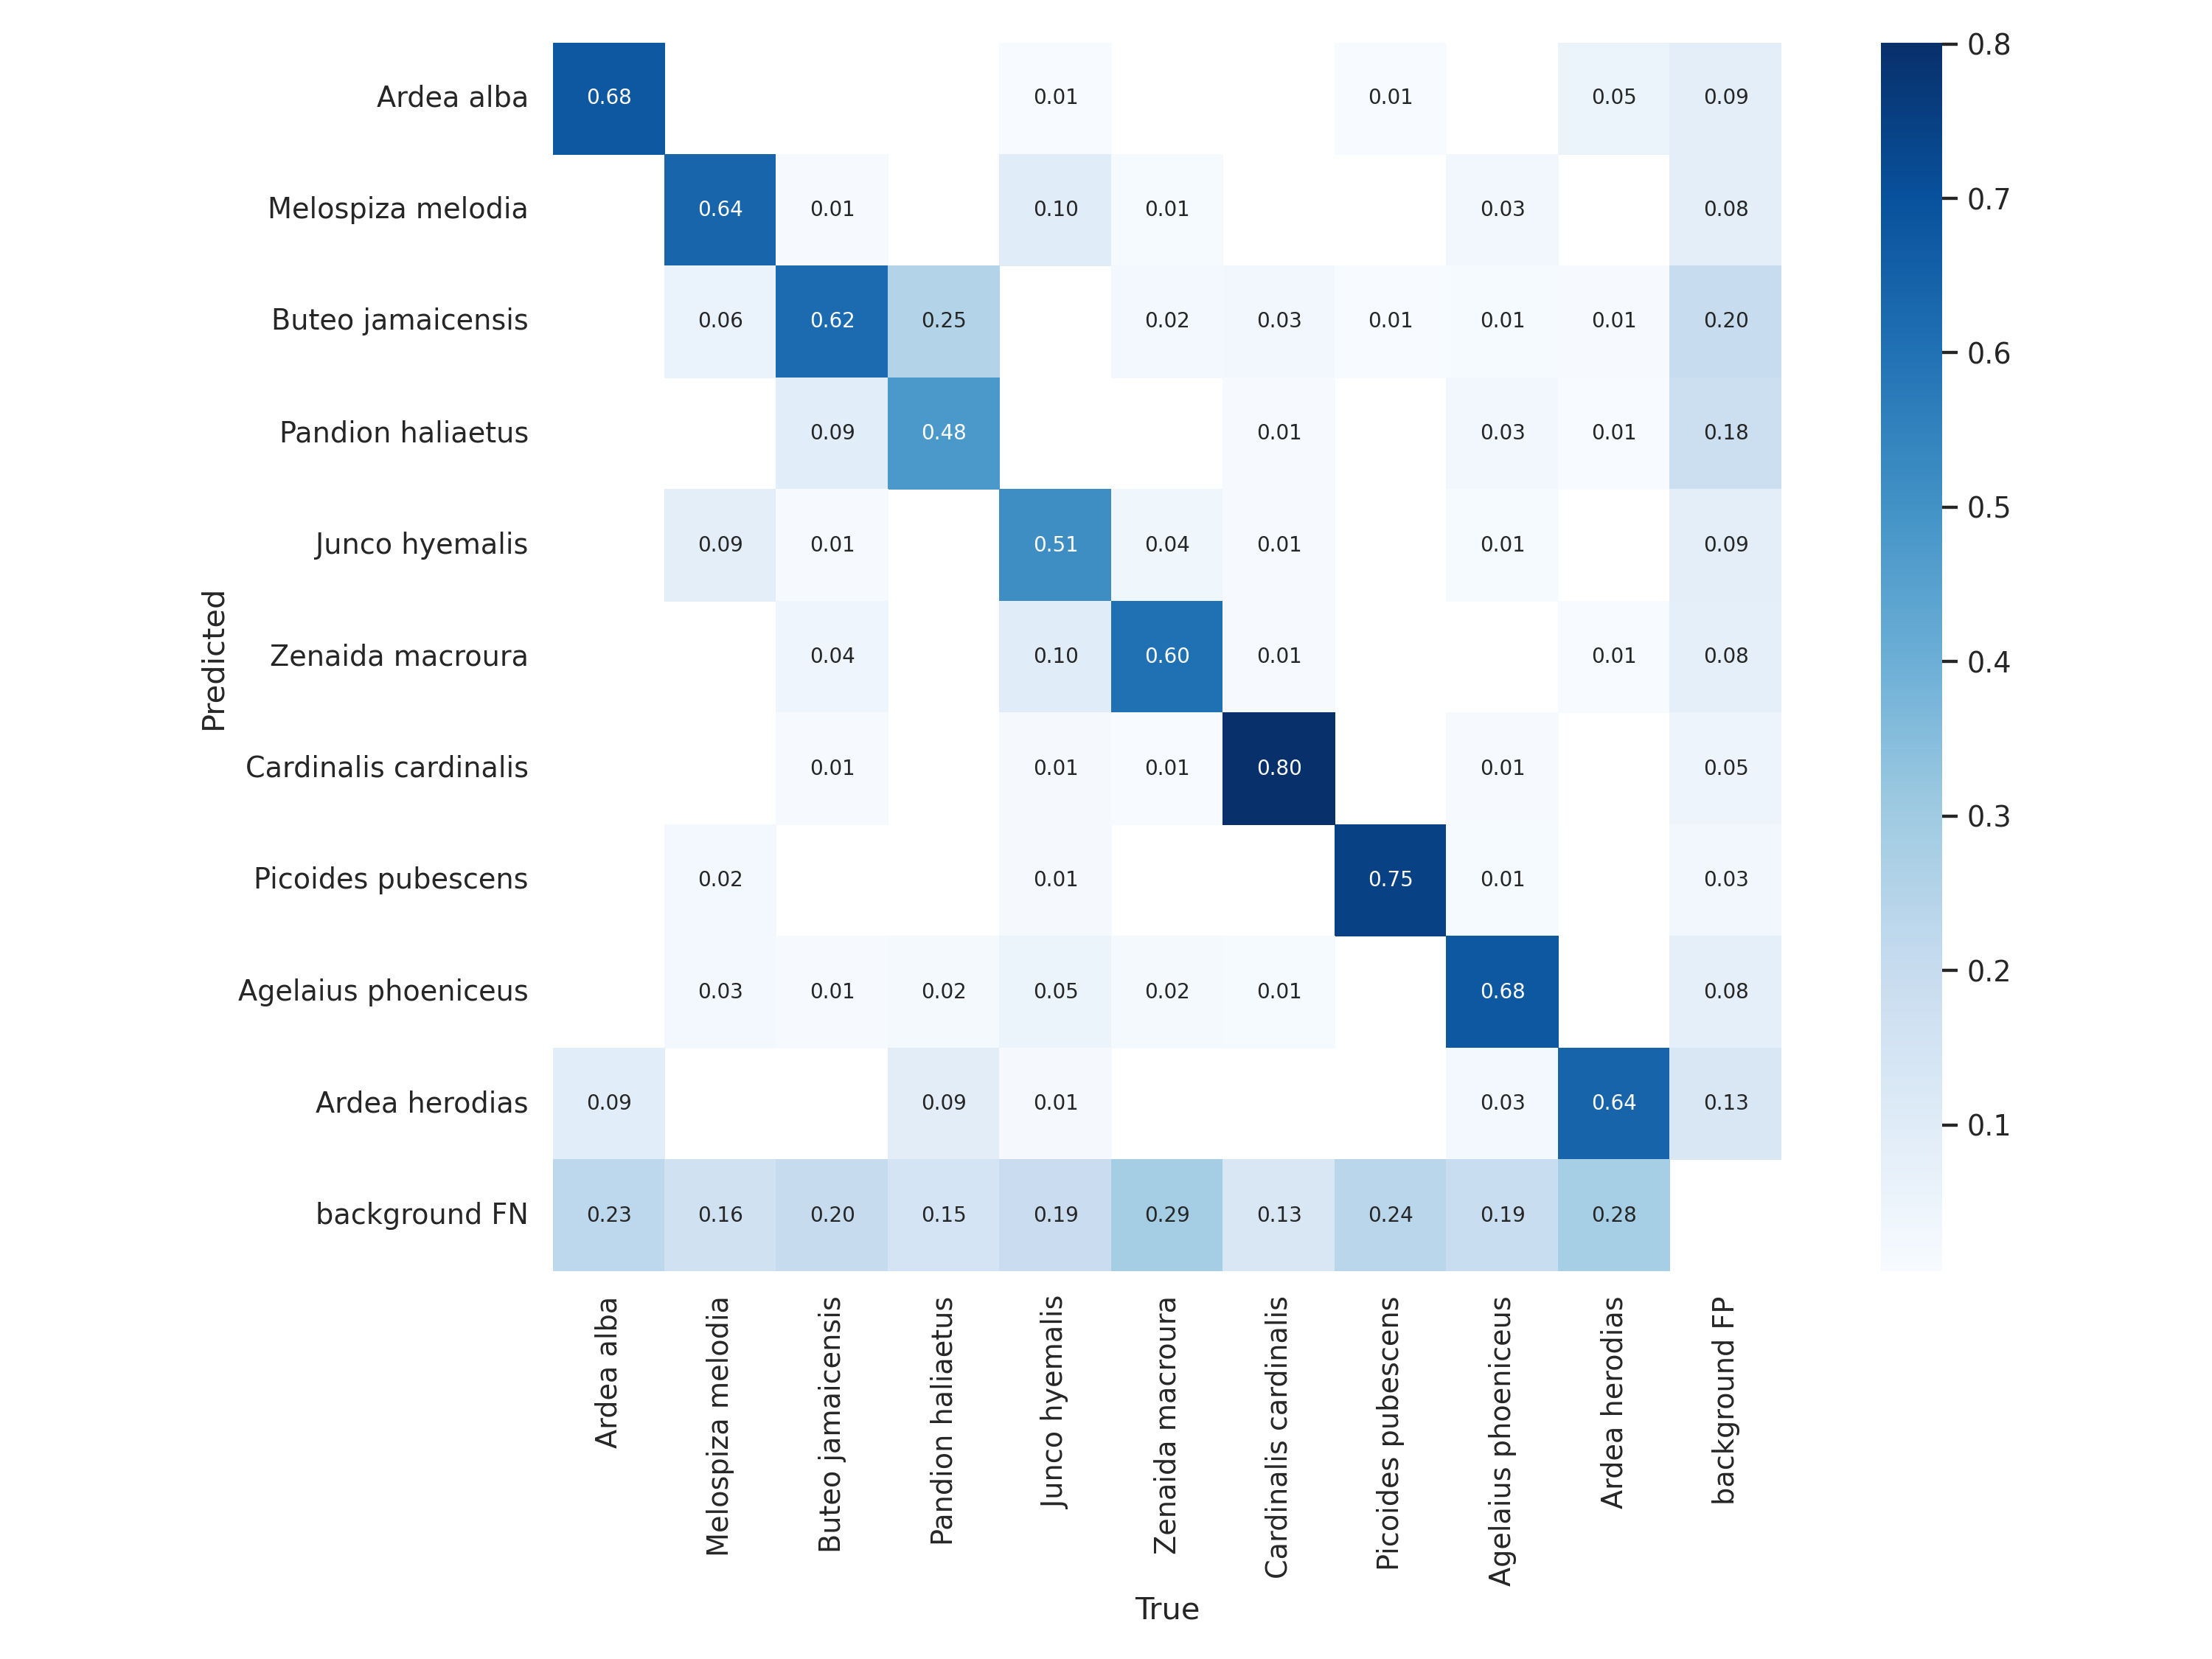

In [5]:
Image.open("runs/train/aves_under/confusion_matrix.png")

## 4. Oversampled Model <a class="anchor" id="over_m"></a>

Here we are training our model using the oversampled dataset. In this case we took the largest class (Ardea herodias) and sampled without replacement from all the other classes to obtain a balanced dataset.

In [16]:
!python yolov7/train.py --img-size 256 --cfg yolov7/cfg/training/yolov7-tiny.yaml --hyp yolov7/data/hyp.scratch.custom.yaml \
--batch 8 --epochs 50 --data yolov7/yaml/yolo_aves_over.yaml --weights yolov7/yolov7_training.pt --workers 24 --name "aves_over"

YOLOR 🚀 v0.1-115-g072f76c torch 1.9.0 CUDA:0 (Tesla K80, 11441.25MB)


The mAP is 0.832 (recall that in the first setting was 0.831), which means that we are increasing a lot the number of data, but this isn't sufficient to boost the performance of the model. This may be influenced by the fact that the new portion of data is similar (in the sense that we apply some transformation) to a subset of our data.

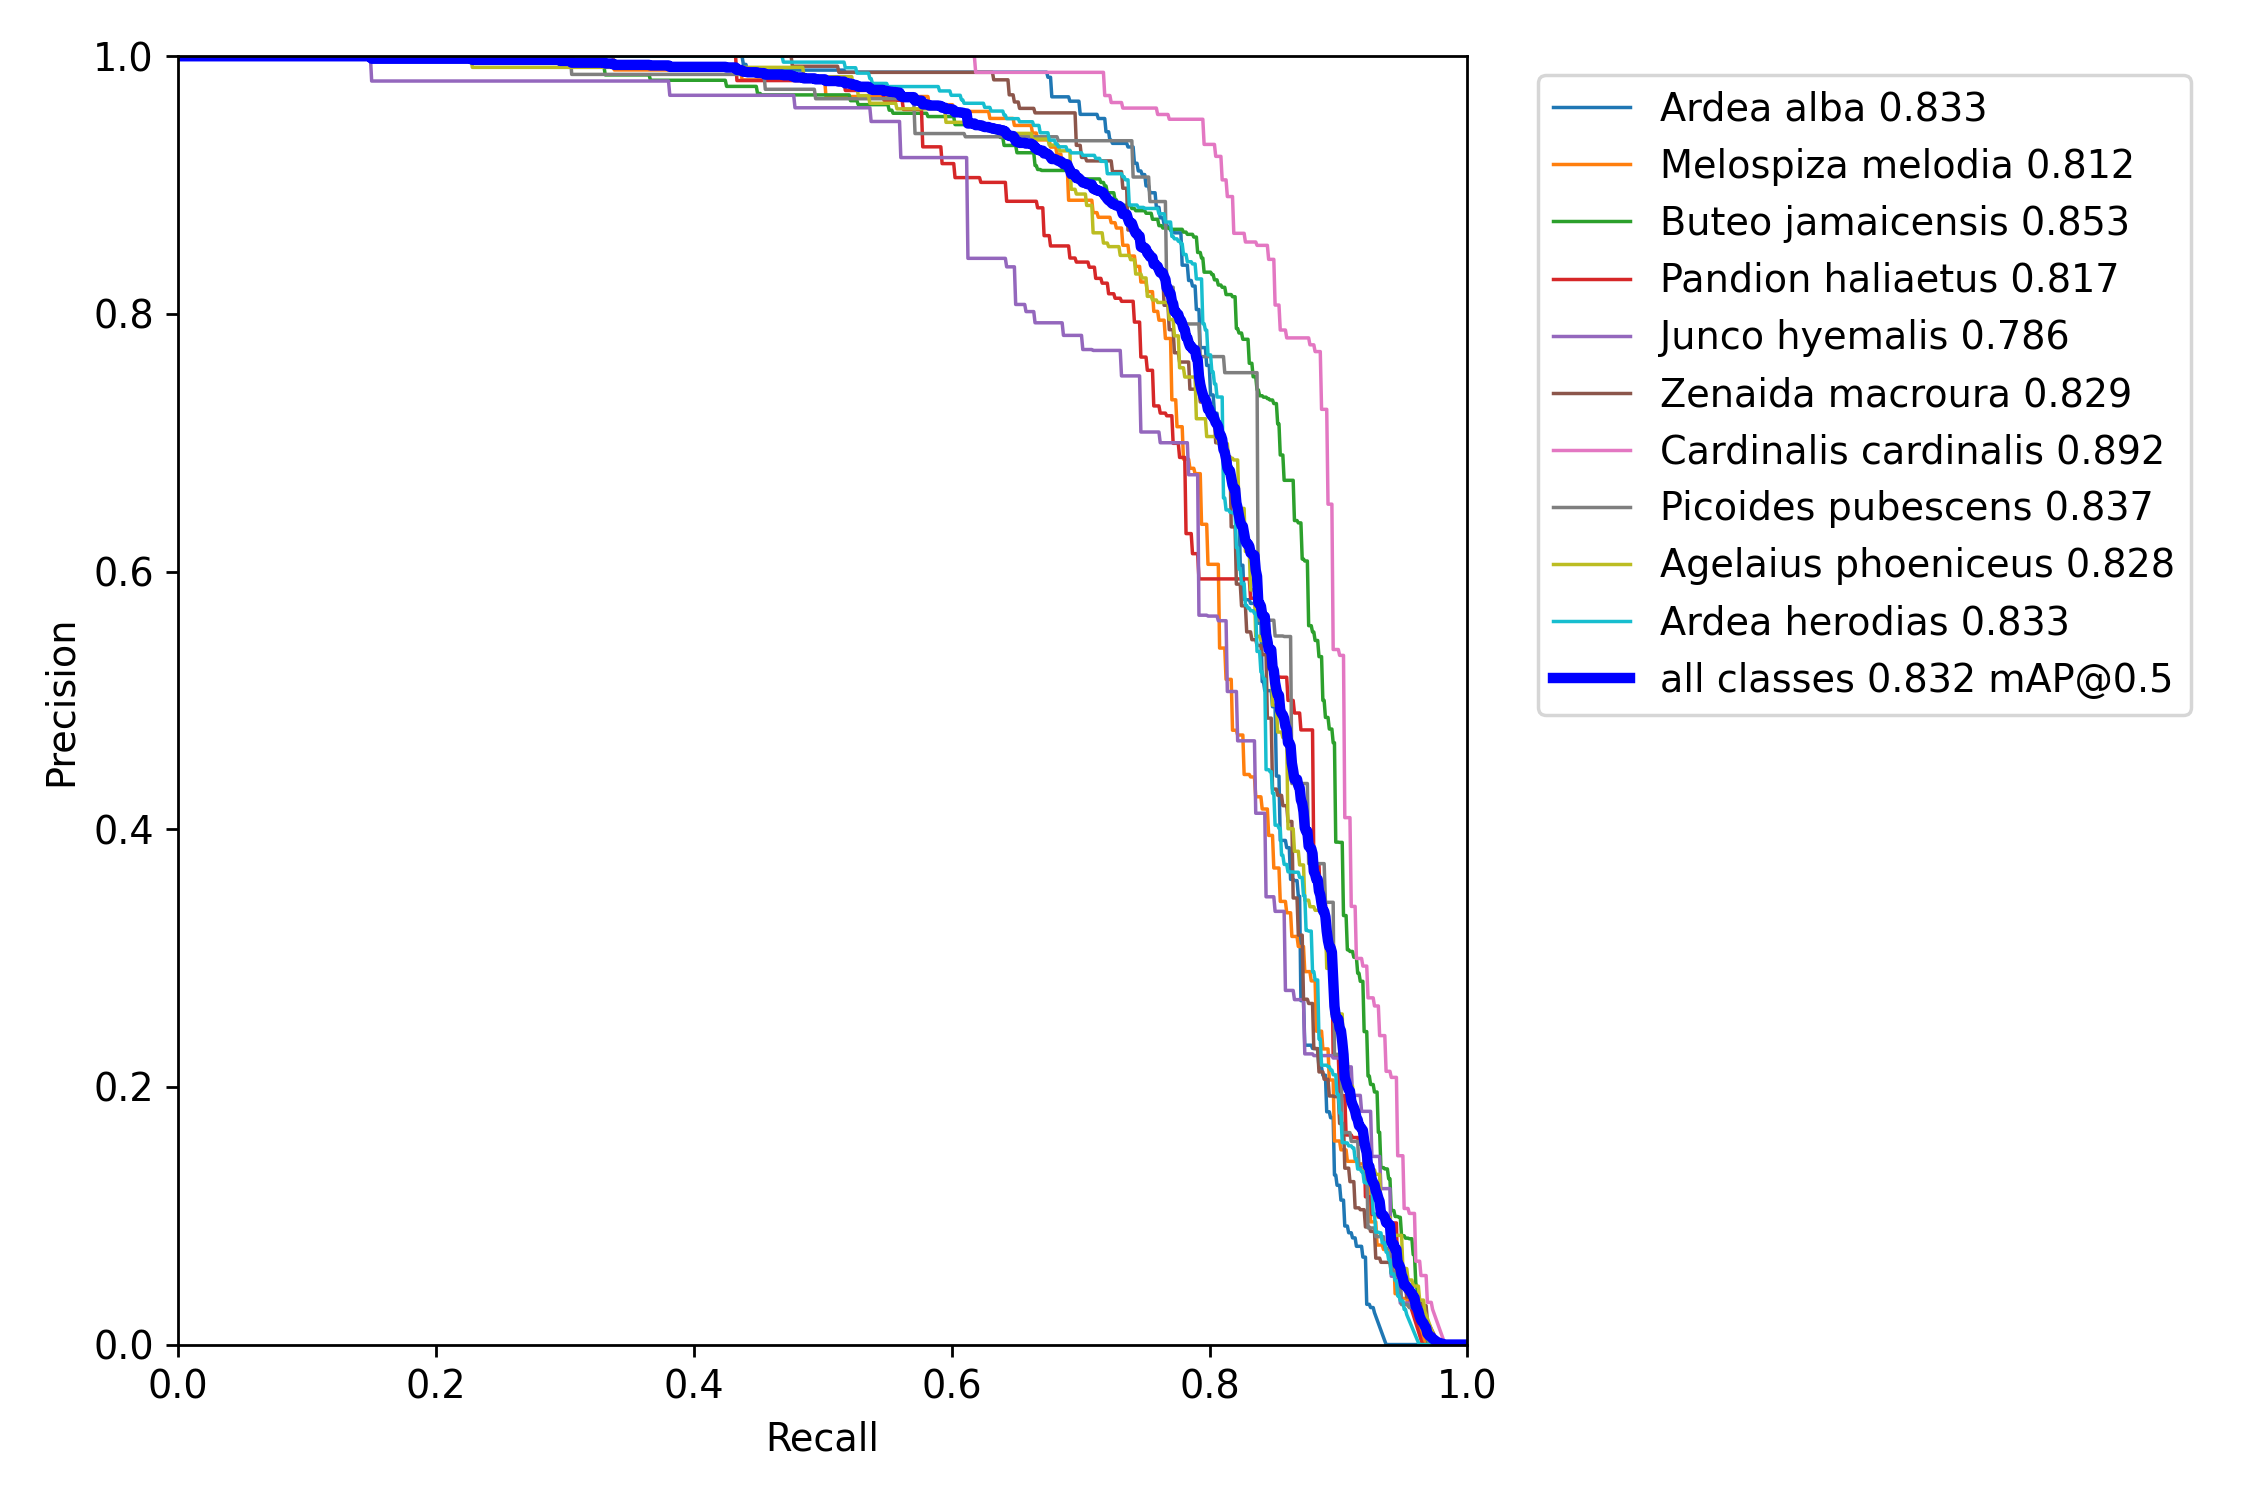

In [18]:
Image.open("runs/train/aves_over/PR_curve.png")

Also the confusion matrix suggests that the improvement in the performance isn't sufficient to justify the large amoung of data we added, and consequently the added training time.

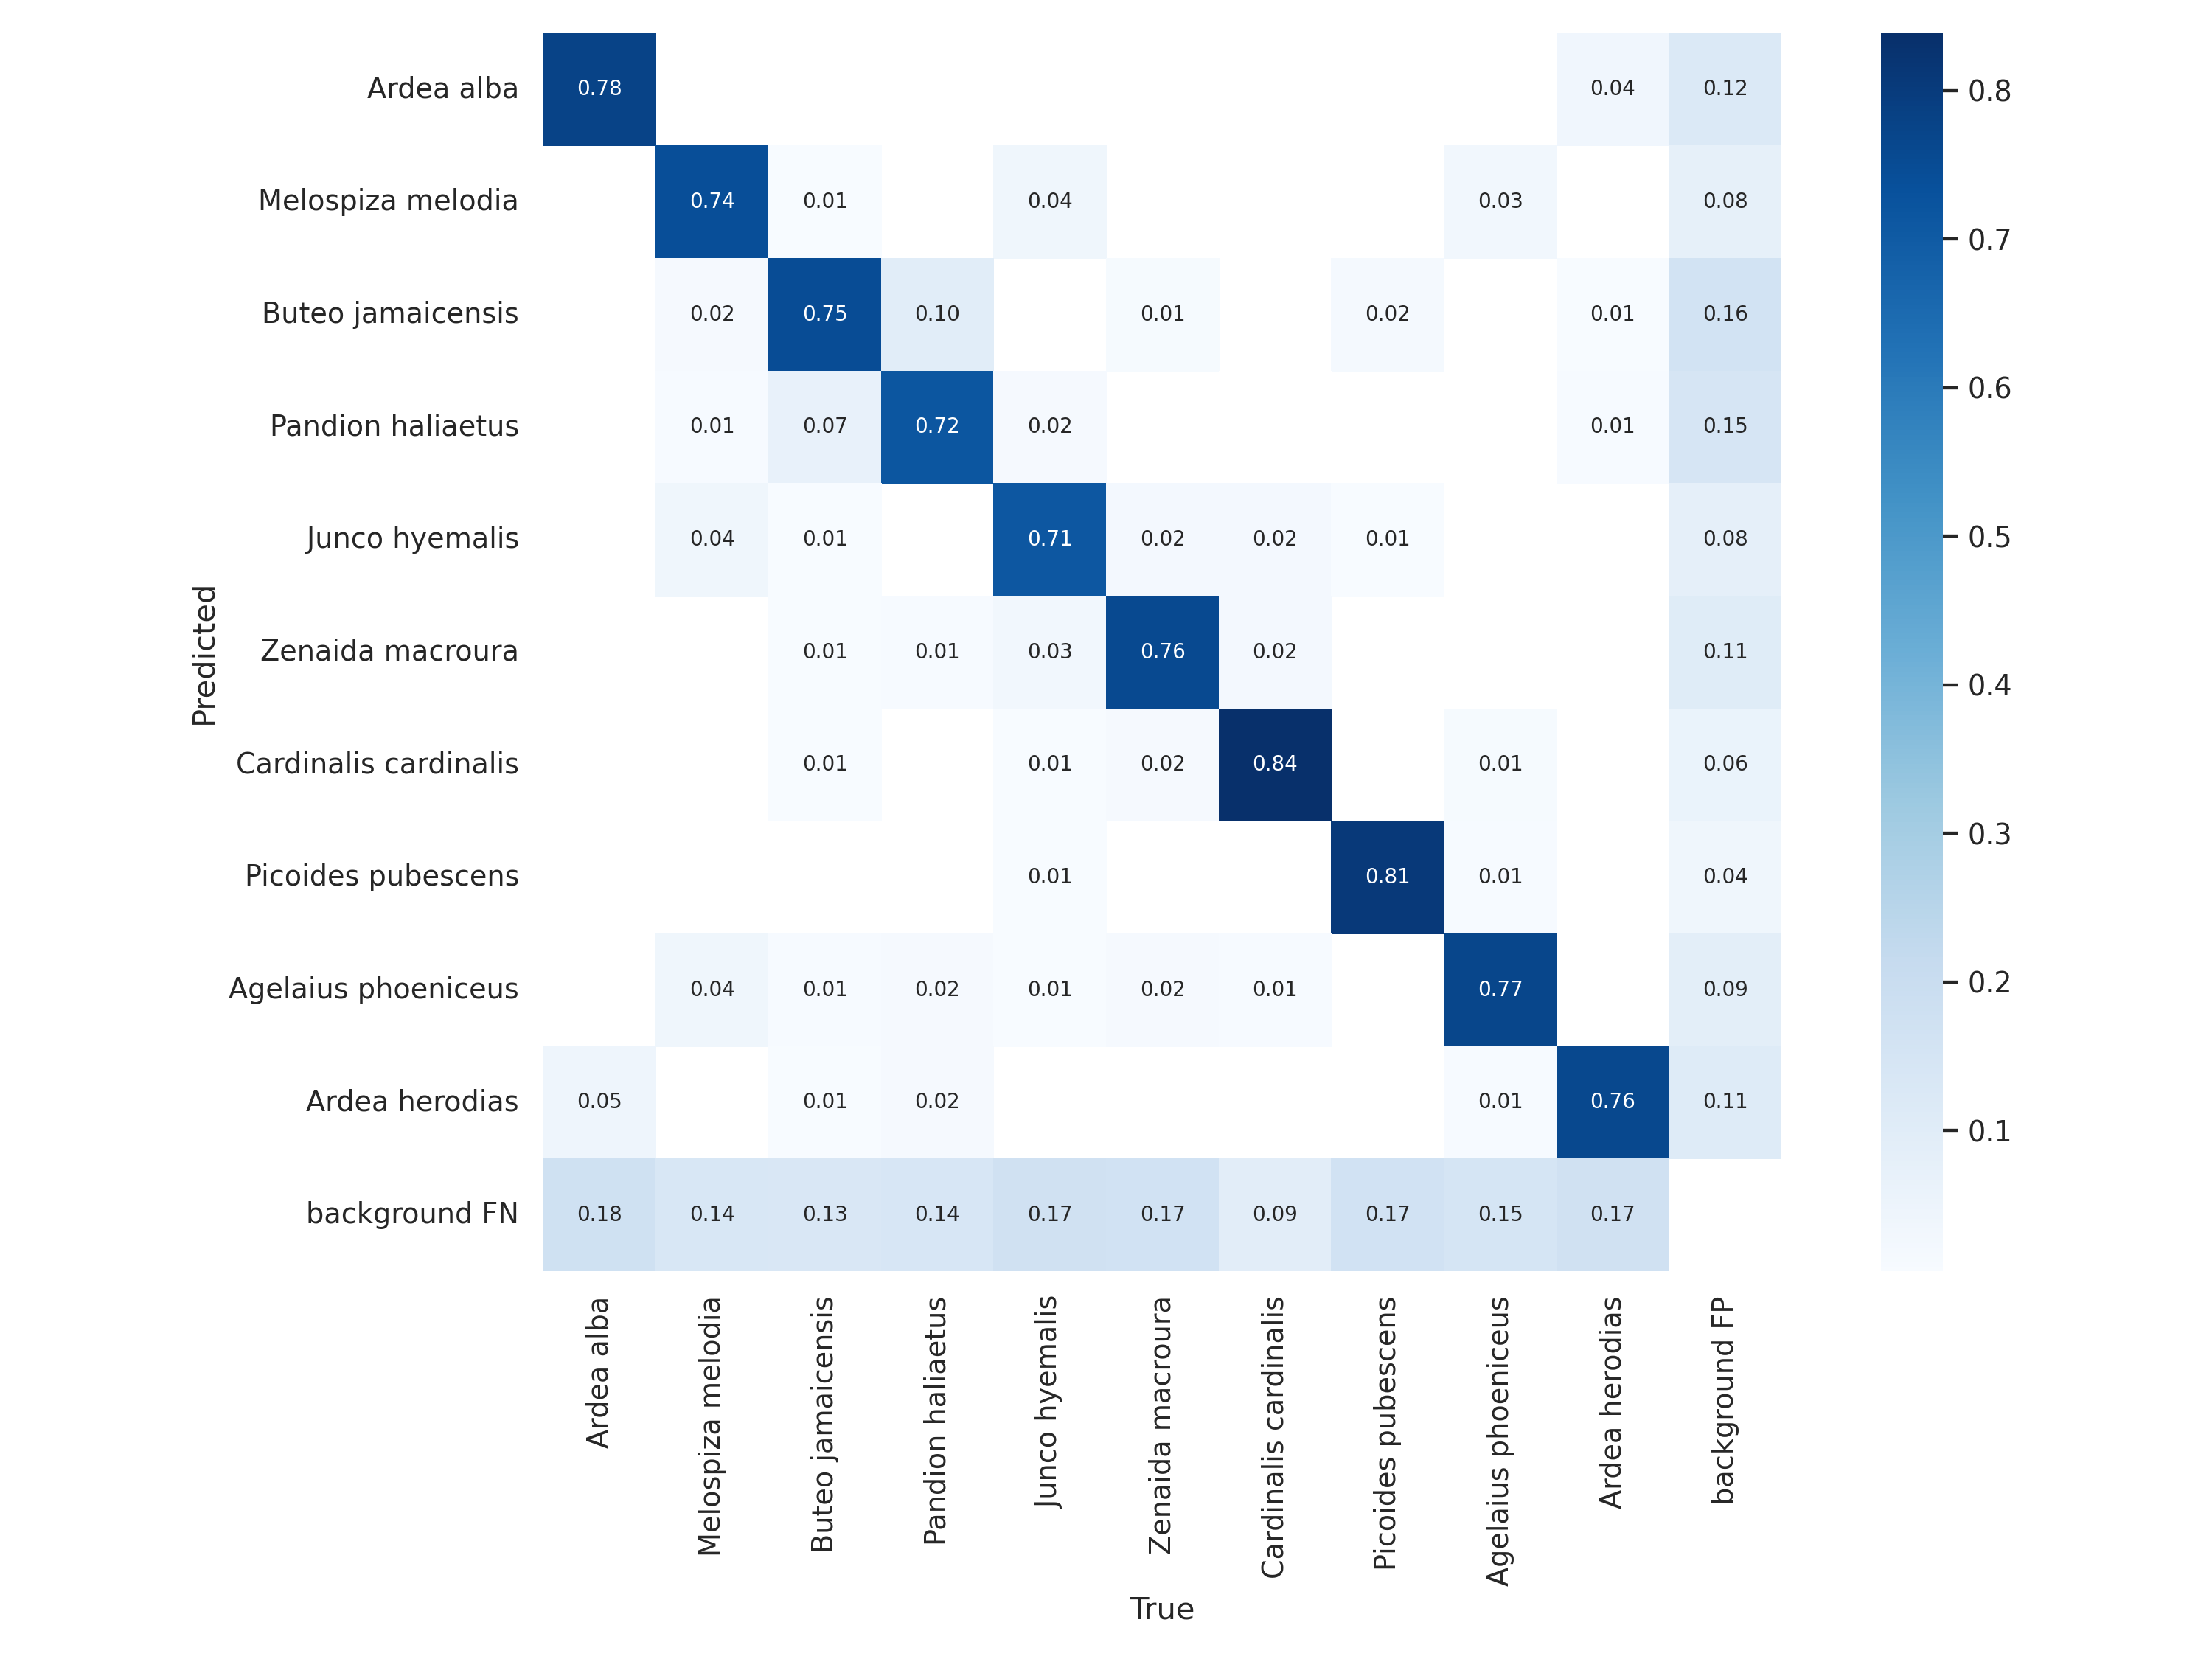

In [6]:
Image.open("runs/train/aves_over/confusion_matrix.png")

## 6. Predict BW images with RGB trained model <a class="anchor" id="sueg"></a>

In [1]:
!python yolov7/test.py --data yolov7/yaml/yolo_aves_bw.yaml --weights runs/train/50_aves/weights/best.pt \
                        --task test --name "colVSbw_test"

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='yolov7/yaml/yolo_aves_bw.yaml', device='', exist_ok=False, img_size=640, iou_thres=0.65, name='colVSbw_test', no_trace=False, project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='test', v5_metric=False, verbose=False, weights=['runs/train/50_aves/weights/best.pt'])
YOLOR 🚀 v0.1-115-g072f76c torch 1.9.0 CUDA:0 (Tesla K80, 11441.25MB)

Fusing layers... 
IDetect.fuse
Model Summary: 208 layers, 6031950 parameters, 0 gradients
 Convert model to Traced-model... 
/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kerne

Here we test our RGB model on BW images. The mAP drops to 0.485. Both in PR curve and confusion matrix we see that the model hardly recognize the Cardinalis (remember is the red one). 

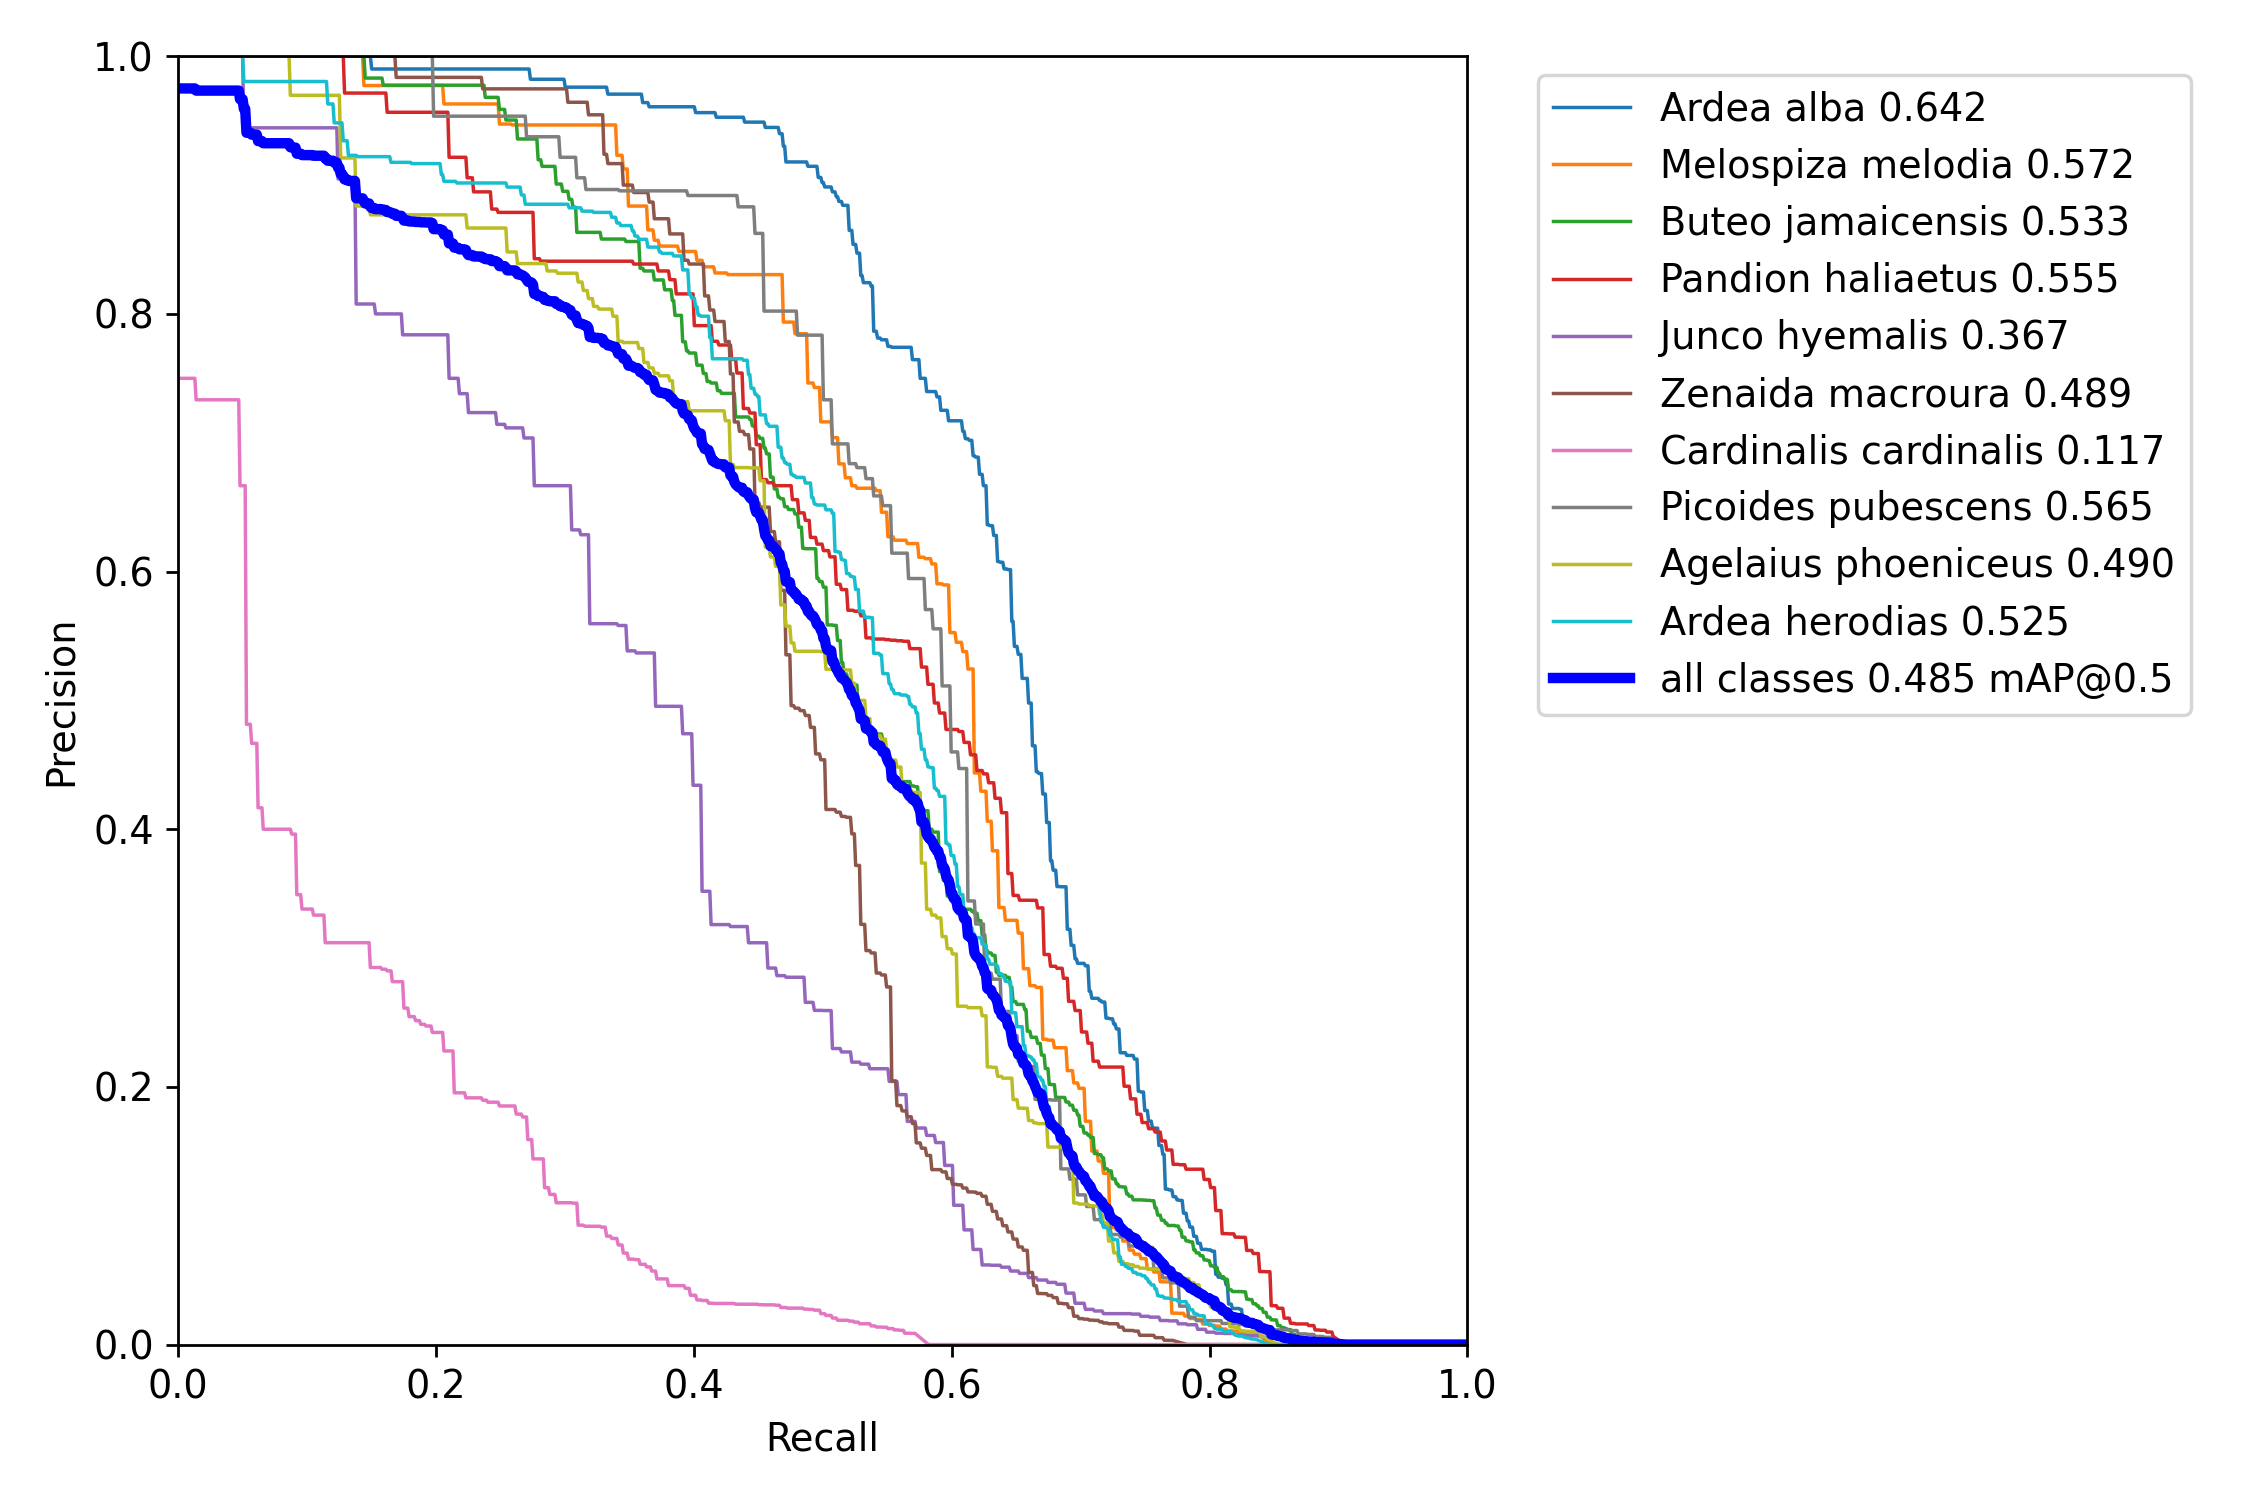

In [5]:
Image.open("runs/test/colVSbw_test/PR_curve.png")

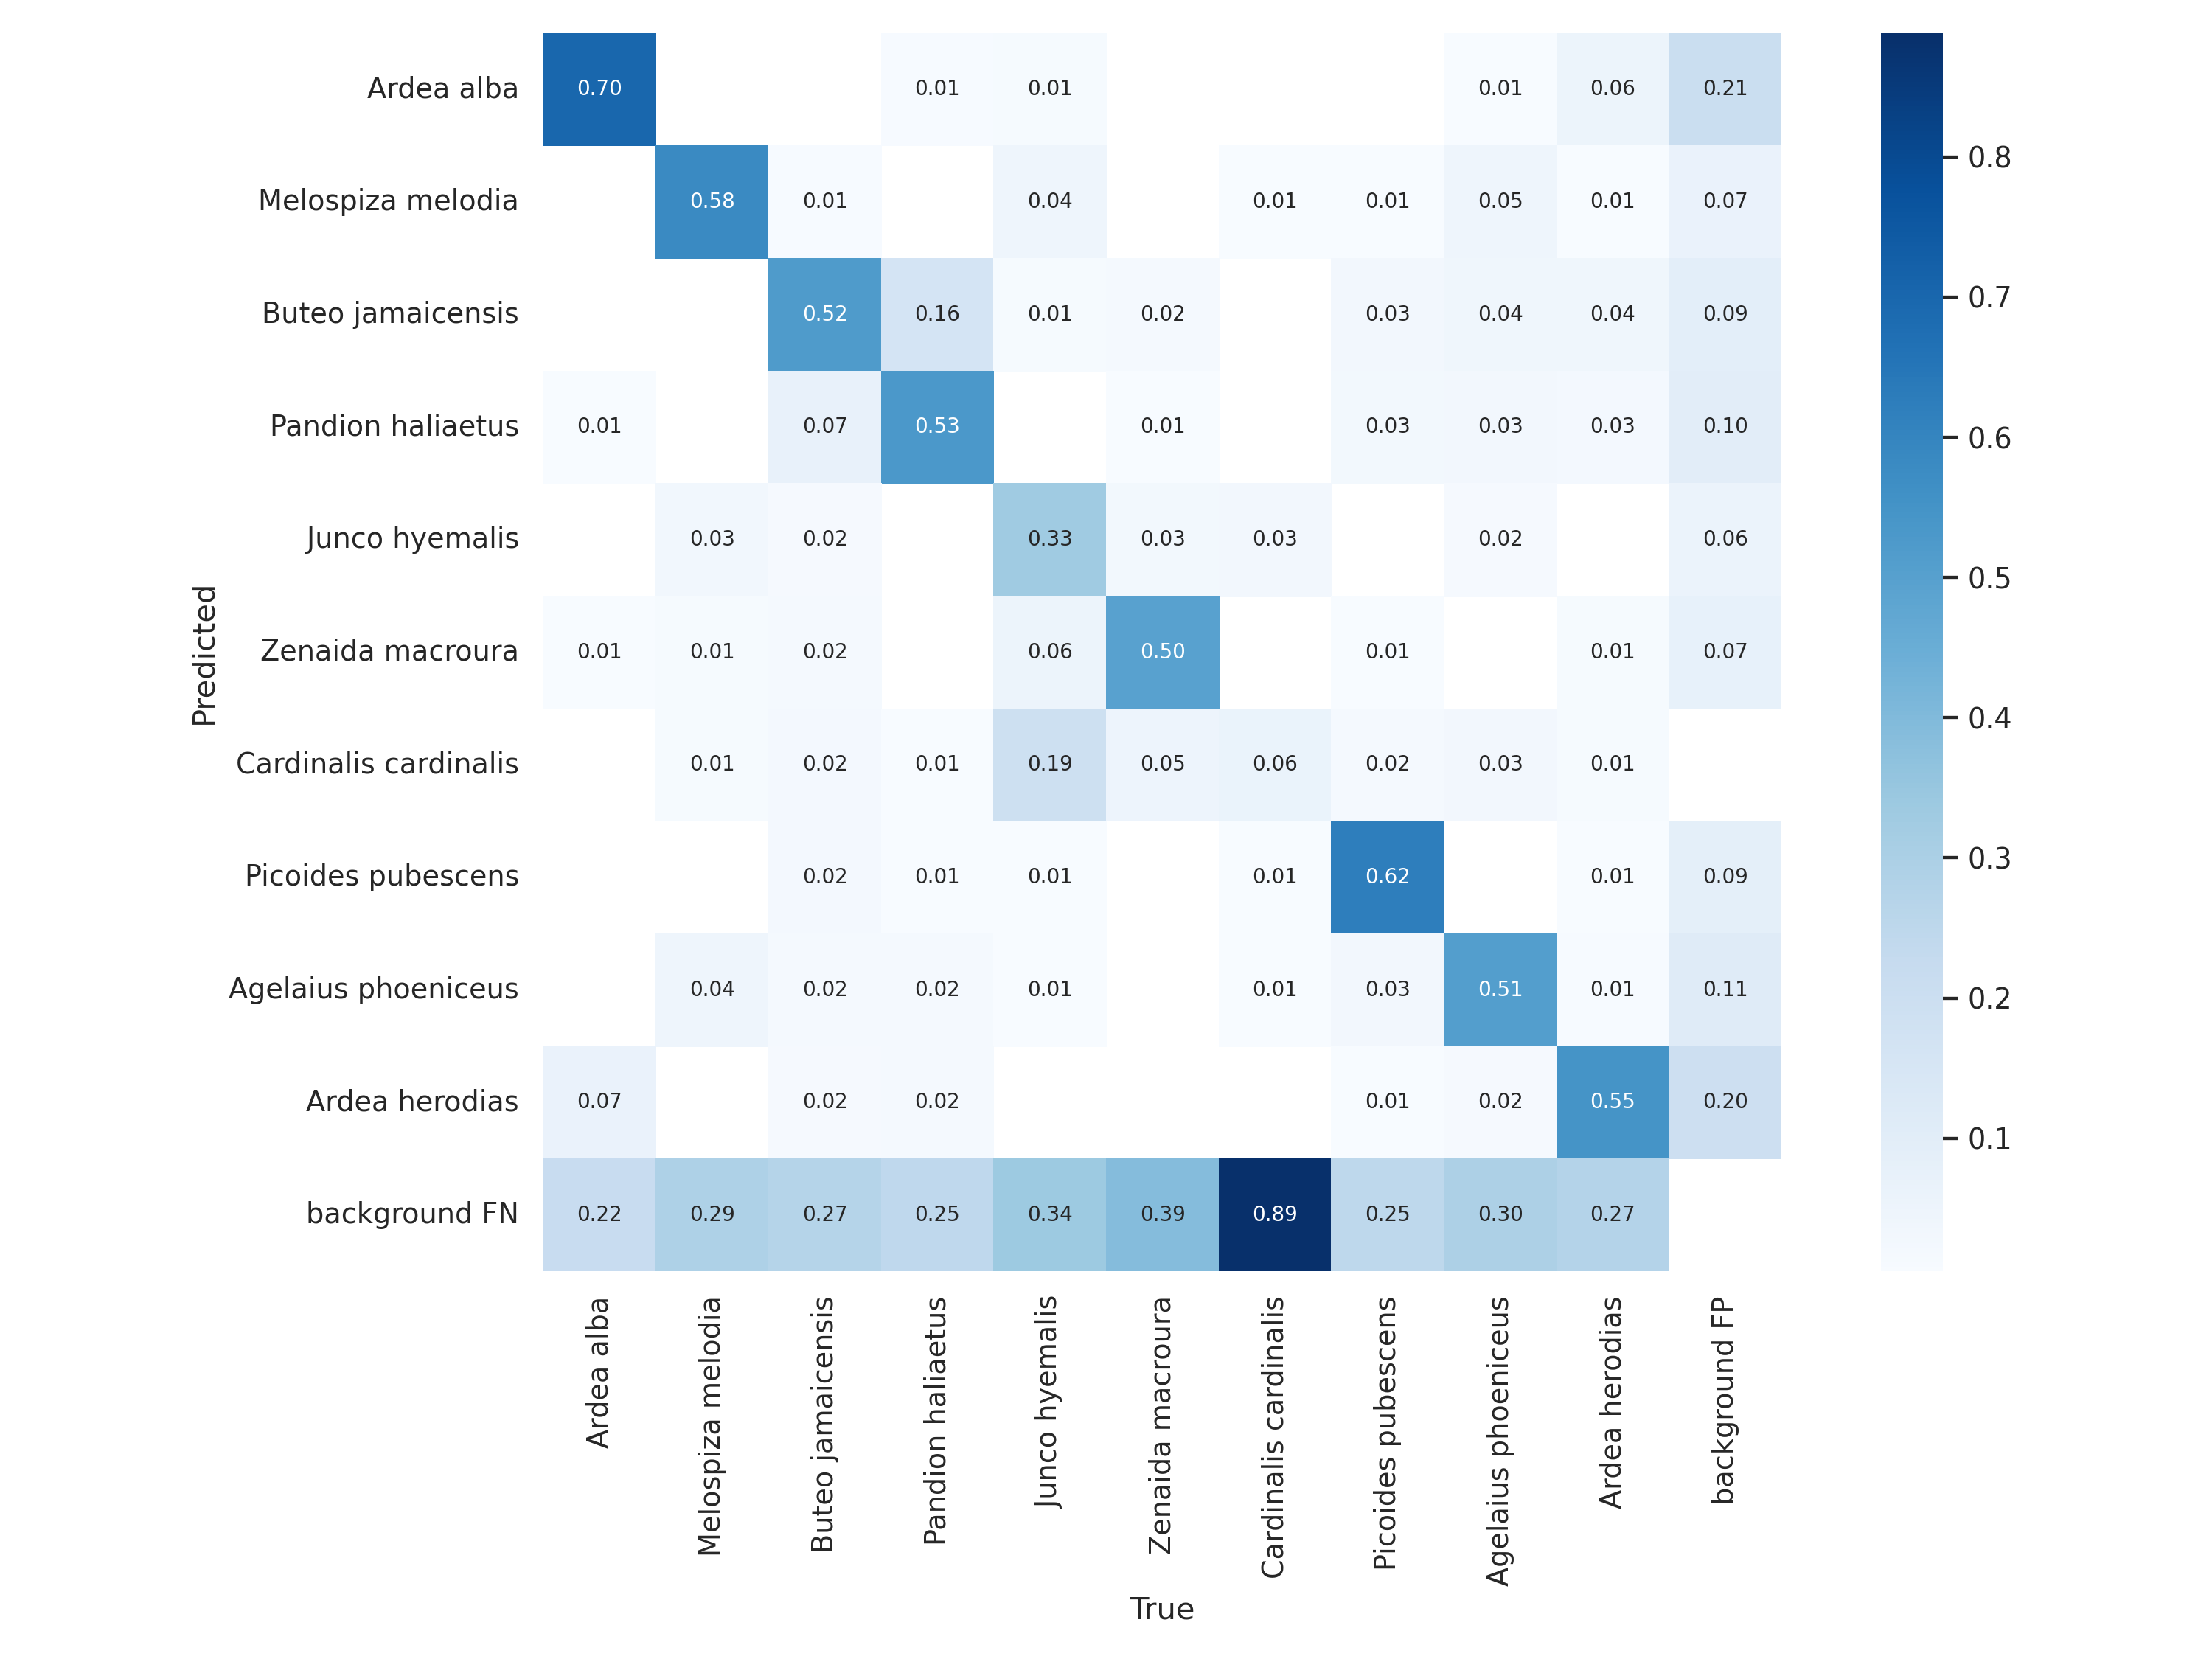

In [4]:
Image.open("runs/test/colVSbw_test/confusion_matrix.png")

## 7. Colorized inference <a class="anchor" id="colorized"></a>

In [2]:
!python yolov7/test.py --data yolov7/yaml/yolo_aves_colorized.yaml --weights runs/train/50_aves/weights/best.pt \
                        --task test --name "colorized_inference"

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='yolov7/yaml/yolo_aves_colorized.yaml', device='', exist_ok=False, img_size=640, iou_thres=0.65, name='colorized_inference', no_trace=False, project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='test', v5_metric=False, verbose=False, weights=['runs/train/50_aves/weights/best.pt'])
YOLOR 🚀 v0.1-115-g072f76c torch 1.9.0 CUDA:0 (Tesla K80, 11441.25MB)

Fusing layers... 
IDetect.fuse
Model Summary: 208 layers, 6031950 parameters, 0 gradients
 Convert model to Traced-model... 
/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2

Comparing this model with first one, we observe that mAP reduces to 0.49. This is related to the fact that we are using a Colorizer and the performance of model is affected by this. Indeed, we observe that YOLO struggles in correctly identifying and classifying Cardinalis (this is visible both in PR curve and confusion matrix). As we can see in the next plot, GAN model doesn't recolorize the image in a perfect way. Obviously, this improves with respect to [Section 6](#sueg), since there we didn't any clue on the colors.

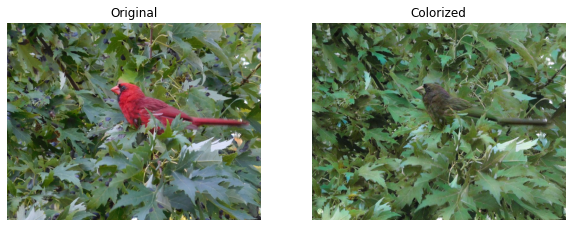

In [5]:
# create figure
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 1
columns = 2

# reading images
Image1 = cv2.imread("data/images/Test/03b8b37b1d6880eba2e33bb4ca882de6.jpg")
Image1 = cv2.cvtColor(Image1, cv2.COLOR_BGR2RGB)
Image2 = cv2.imread("colorized/images/Test/03b8b37b1d6880eba2e33bb4ca882de6.jpg")
Image2 = cv2.cvtColor(Image2, cv2.COLOR_BGR2RGB)

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Original")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Colorized");

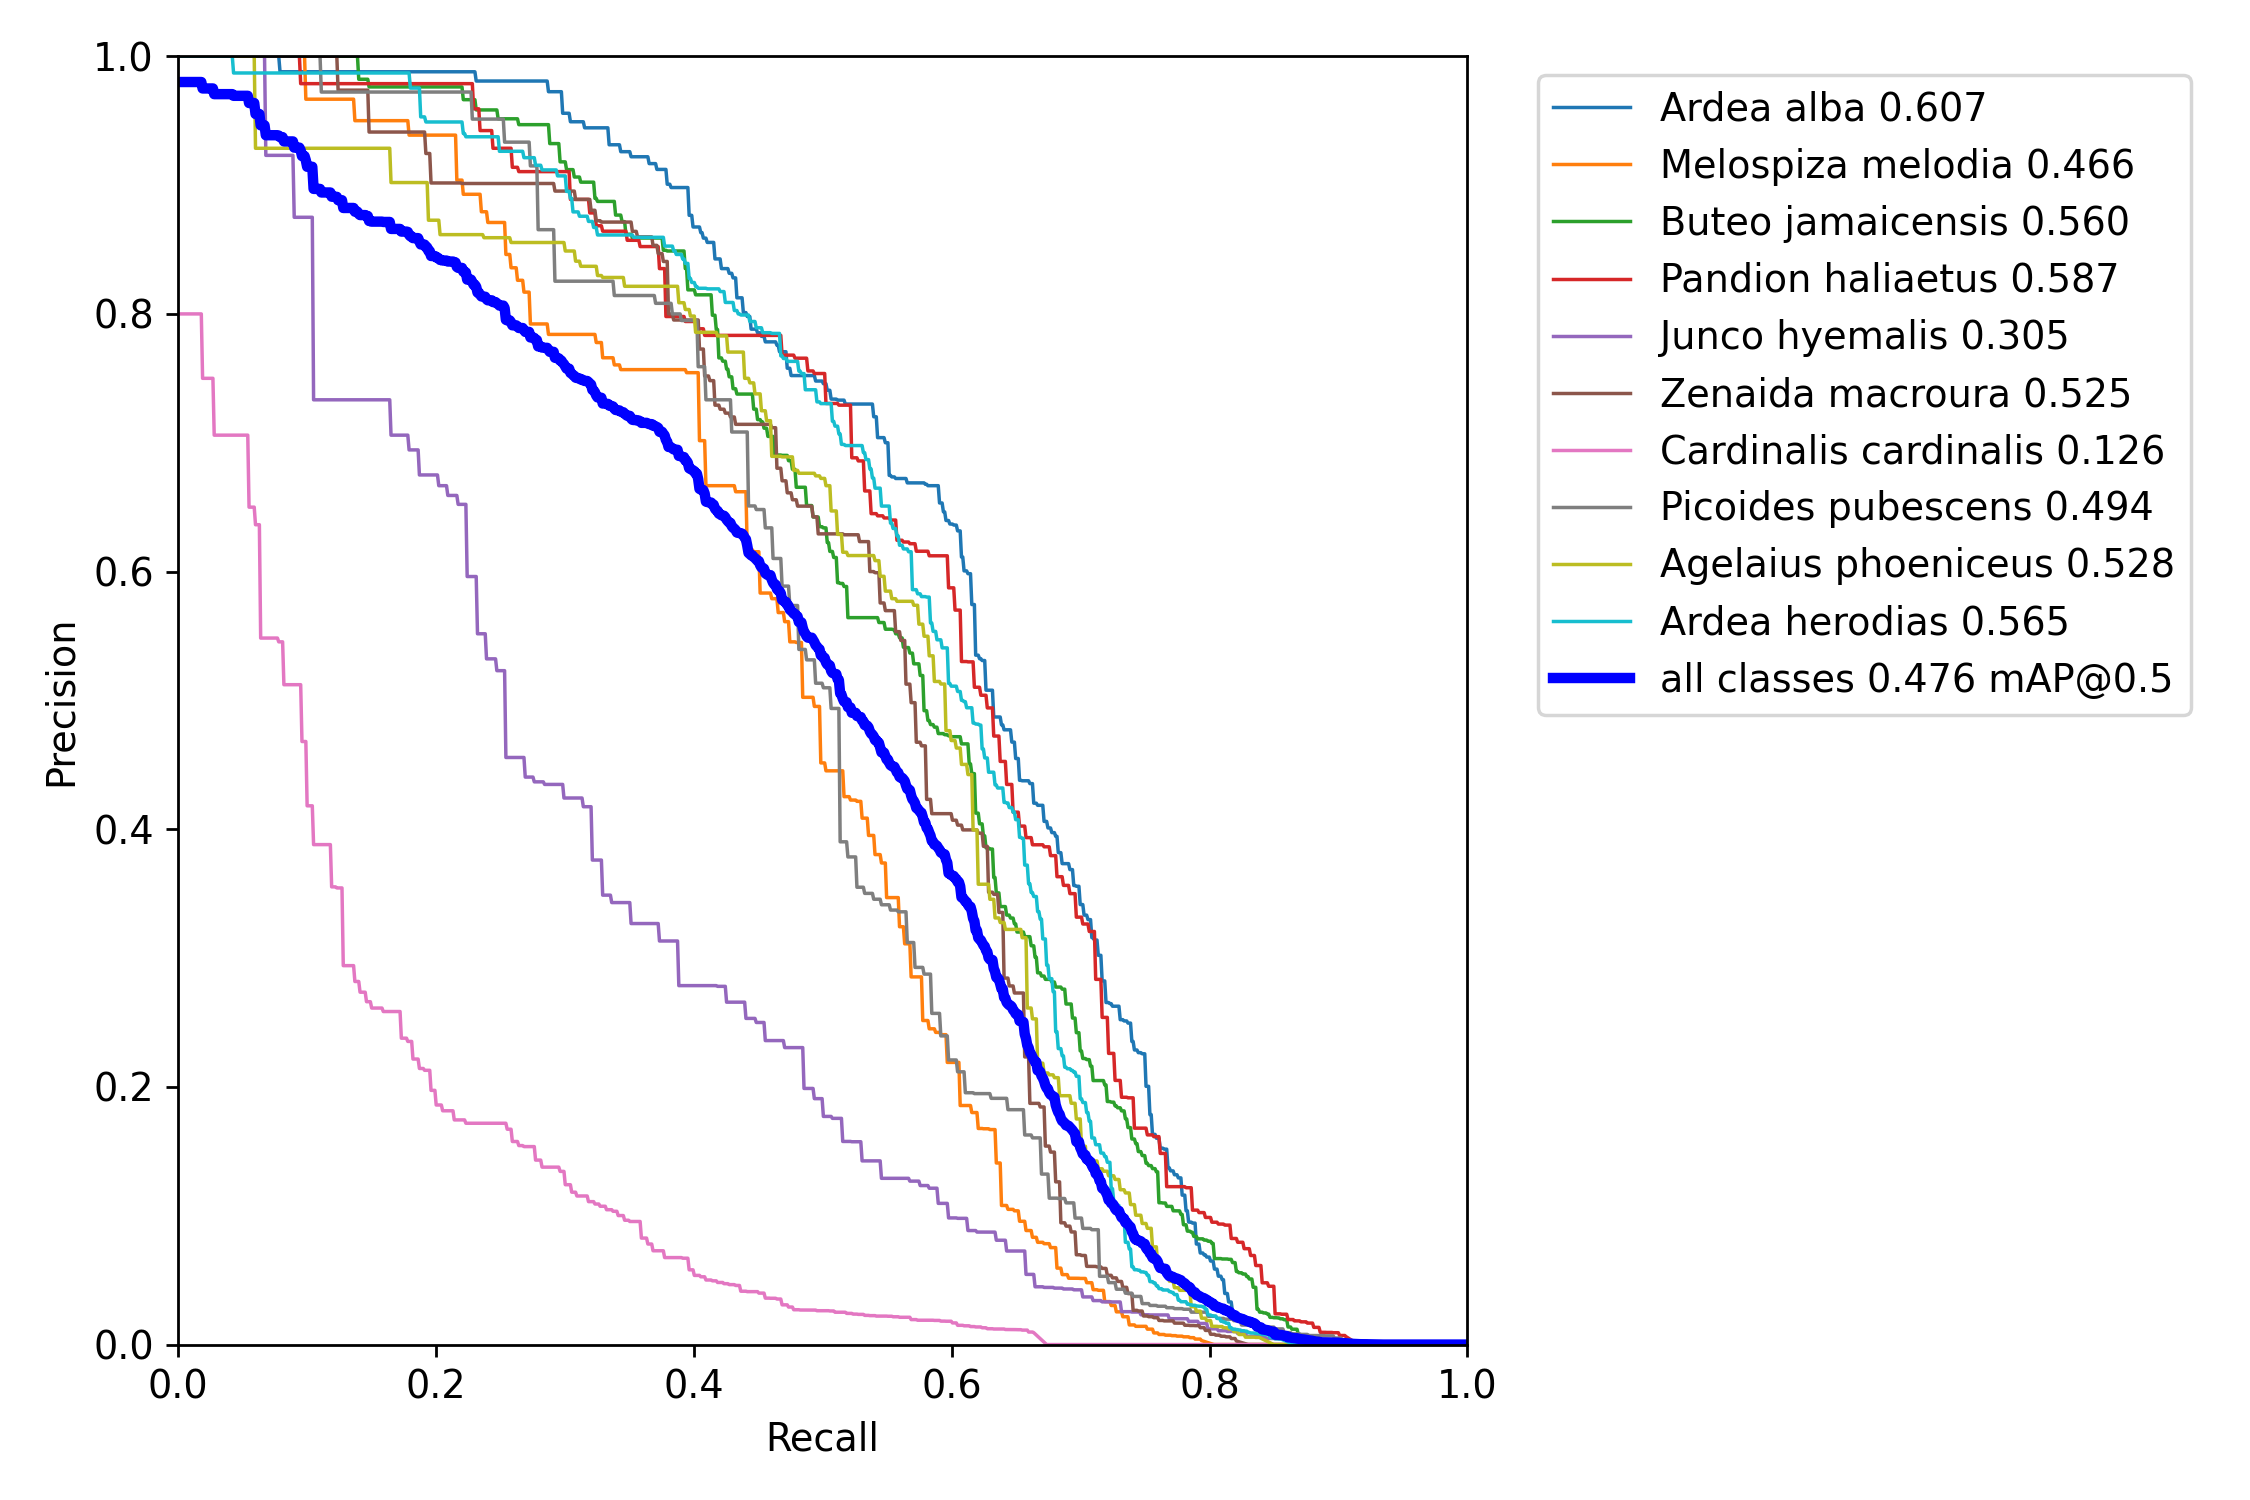

In [5]:
Image.open("runs/test/colorized_inference/PR_curve.png")

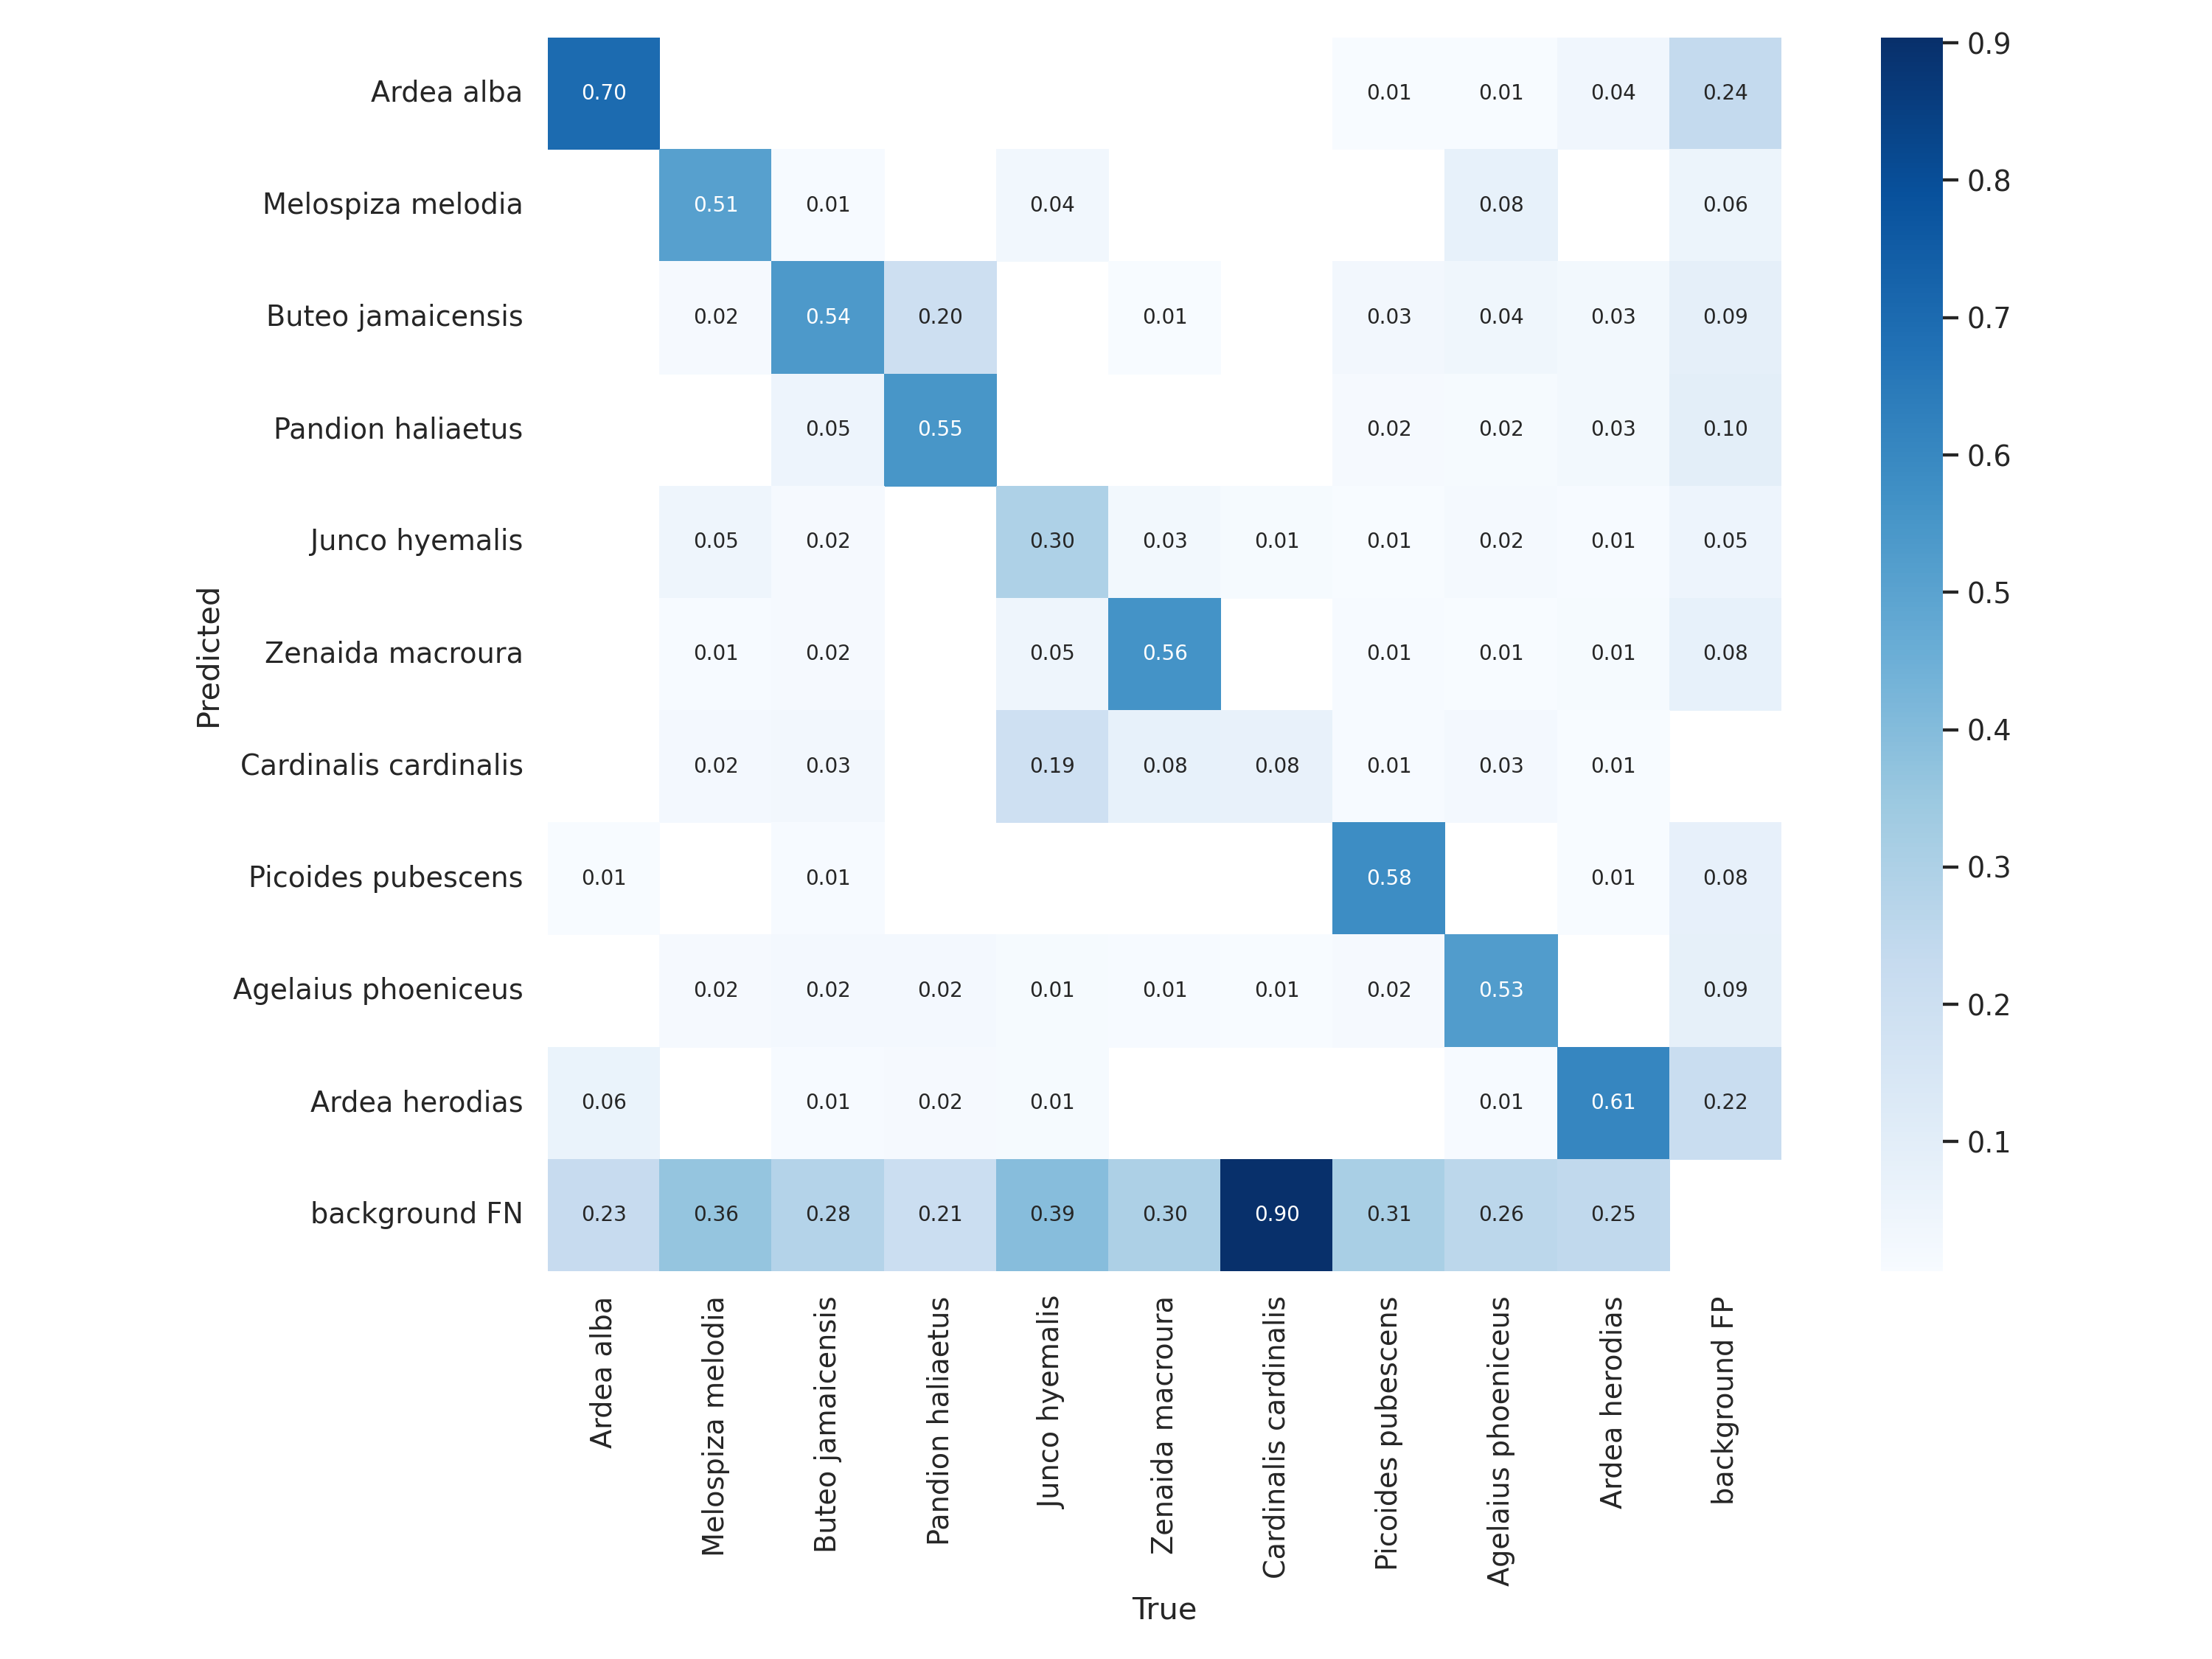

In [6]:
Image.open("runs/test/colorized_inference/confusion_matrix.png")

## 8. Final test <a class="anchor" id="final"></a>

In [3]:
!python yolov7/test.py --data yolov7/yaml/yolo_aves.yaml --weights runs/train/50_aves/weights/best.pt \
                        --task test --img-size 256 --name "final_val"

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='yolov7/yaml/yolo_aves.yaml', device='', exist_ok=False, img_size=256, iou_thres=0.65, name='final_val', no_trace=False, project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='test', v5_metric=False, verbose=False, weights=['runs/train/50_aves/weights/best.pt'])
YOLOR 🚀 v0.1-115-g072f76c torch 1.9.0 CUDA:0 (Tesla K80, 11441.25MB)

Fusing layers... 
IDetect.fuse
Model Summary: 208 layers, 6031950 parameters, 0 gradients
 Convert model to Traced-model... 
/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size

Final running time to predict on the test: 49 seconds

## 9. Video detection <a class="anchor" id="video"></a>

In [ ]:
!python yolov7/detect.py --source ardea_alba.mp4 --weights runs/train/50_aves/weights/best.pt \
                         --conf 0.35 --name "ardea_video"

In [ ]:
!python yolov7/detect.py --source cardinalis.mp4 --weights runs/train/50_aves/weights/best.pt \
                         --conf 0.35 --name "ardea_video"

In [1]:
from IPython.display import YouTubeVideo

[YouTube video link](https://www.youtube.com/watch?v=Ks11U4TR5H4)

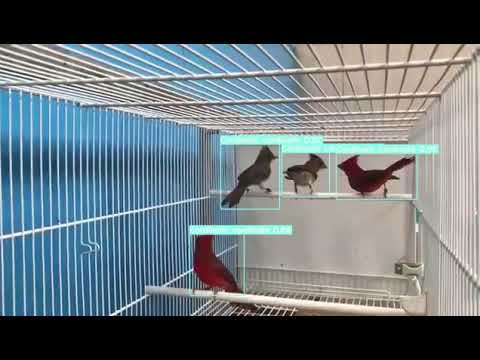

In [6]:
YouTubeVideo('Ks11U4TR5H4', width=560, height=315)

[YouTube video link](https://www.youtube.com/watch?v=0ILkHS5kYU8)

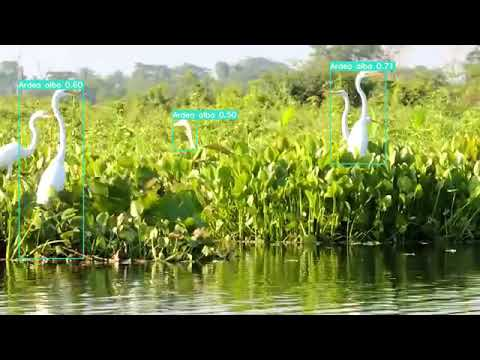

In [7]:
YouTubeVideo('0ILkHS5kYU8', width=560, height=315)